## 1. Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from dataclasses import dataclass
from typing import Optional, Dict, Any

from ramanlib.core import convert_to_spectral_data, SpectralData
from ramanlib.bleaching import (
    decompose,
    DecompositionResult,
    solve_spectra_given_rates,
    load_fluorophores,
    SyntheticConfig,
    SyntheticBleachingDataset,
)
from ramanlib.loading import load_data

from ramanlib.plot import compare_spectra
from ramanlib.bleaching.visualize import (
    visualize_decomposition_3d,
    visualise_decomposition,
    get_fluorophore_corrs,
    plot_temporal_decomposition,
    plot_decomposition,
    visualize_data_3d
)

%load_ext autoreload
%autoreload 2

## 2. Load Real Data

In [2]:
# Load real bleaching data
real_data = np.loadtxt('./data/bleaching/data_50x filter 8 0.1 s _all spectra.txt')

# First row is wavenumbers, rest is intensity time series
wn_real = real_data[0, :]
Y_real = real_data[1:, :]  # Shape: (T, W)

# Acquisition parameters
dt_real = 0.1  # 0.1s between frames
T_real, W_real = Y_real.shape
t_real = np.arange(T_real) * dt_real

# Crop to fingerprint region
crop_mask = (wn_real >= 500) & (wn_real <= 1800)
Y_real_crop = Y_real[:, crop_mask]
wn_real_crop = wn_real[crop_mask]

print(f"Real data: {Y_real_crop.shape} (T={T_real} frames, {t_real[-1]:.1f}s total)")
print(f"Wavenumber range: {wn_real_crop[0]:.0f} - {wn_real_crop[-1]:.0f} cm⁻¹")

# Create SpectralData container for real data 
real_data_spectral = SpectralData(
    intensities=Y_real_crop,
    wavenumbers=wn_real_crop,
    time_values=t_real,
    label='Real bleaching data'
)
print(f"\nCreated SpectralData container: {real_data_spectral.is_time_series=}, {real_data_spectral.n_timepoints=}")

Real data: (128, 554) (T=128 frames, 12.7s total)
Wavenumber range: 501 - 1799 cm⁻¹

Created SpectralData container: real_data_spectral.is_time_series=True, real_data_spectral.n_timepoints=128


(<Figure size 3000x500 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

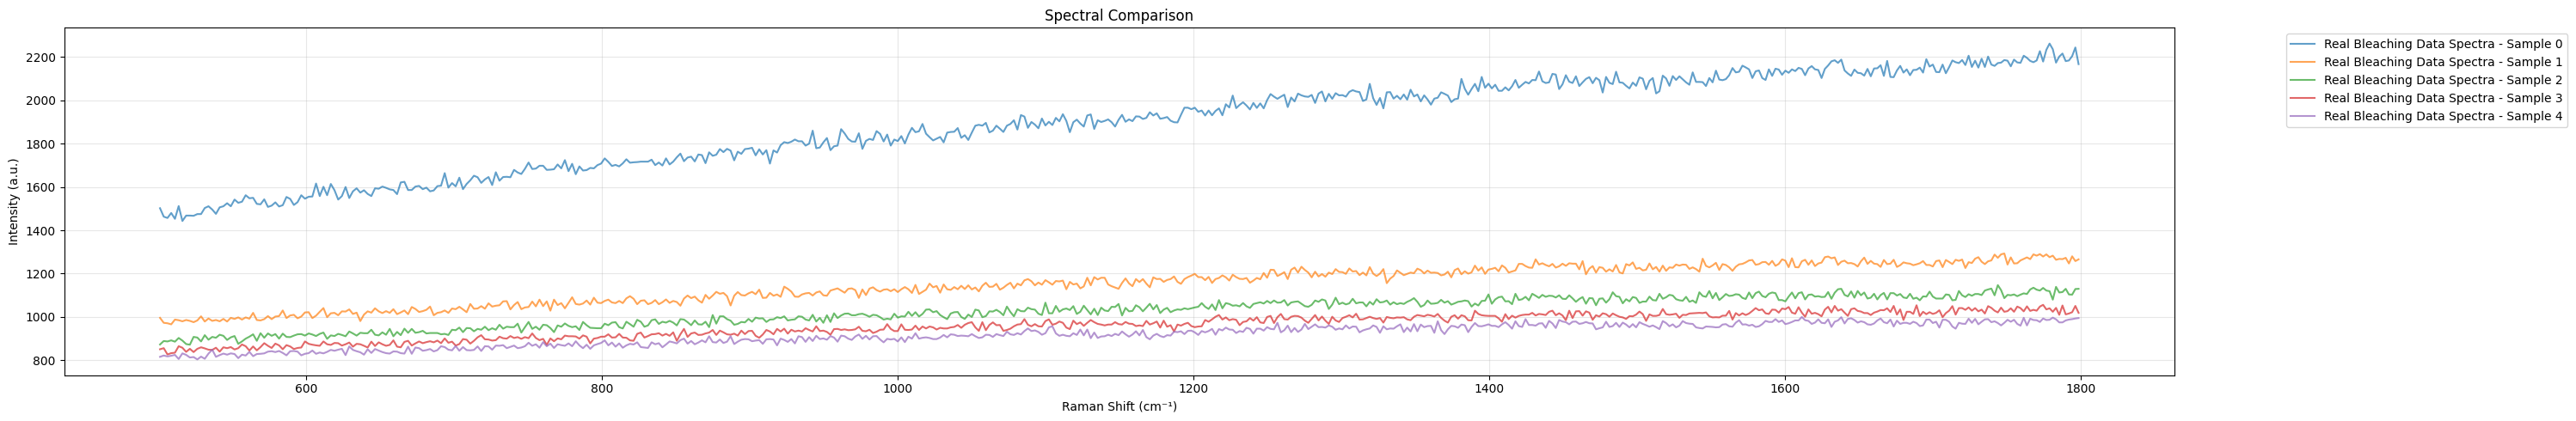

In [6]:
compare_spectra(data=[real_data_spectral], titles=["Real Bleaching Data Spectra"], n_samples=5, height=5)

Filtered: mCardinal em
Filtered: mKate em
Filtered: TagBFP em
Filtered: KillerRed em
Filtered: HcRed7 em
Filtered: TagRFP675 em
Kept 16/22 fluorophores
Found 11250 spectrum files
  -> New calibration set detected (Set #0)
  -> New calibration set detected (Set #1)
  -> New calibration set detected (Set #2)

Successfully loaded 11250 spectra

Loaded 9 strains:
  Strain 12228 (Staphylococcus epidermidis, G+): 1250 spectra
  Strain 19606 (Acinetobacter baumannii, G-): 1250 spectra
  Strain 25922 (Escherichia coli, G-): 1250 spectra
  Strain 25923 (Staphylococcus aureus, G+): 1250 spectra
  Strain 27853 (Pseudomonas aeruginosa, G-): 1250 spectra
  Strain 29212 (Enterococcus faecalis, G+): 1250 spectra
  Strain 29213 (Staphylococcus aureus, G+): 1250 spectra
  Strain 35218 (Escherichia coli, G-): 1250 spectra
  Strain 700603 (Klebsiella Pneumoniae, G-): 1250 spectra

=== Outlier Removal Summary ===
Strain 12228: Orig: 375, Rm: 4 (Sat: 1, Drop: 3)
Strain 19606: Orig: 250, Rm: 7 (Sat: 0, Drop

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

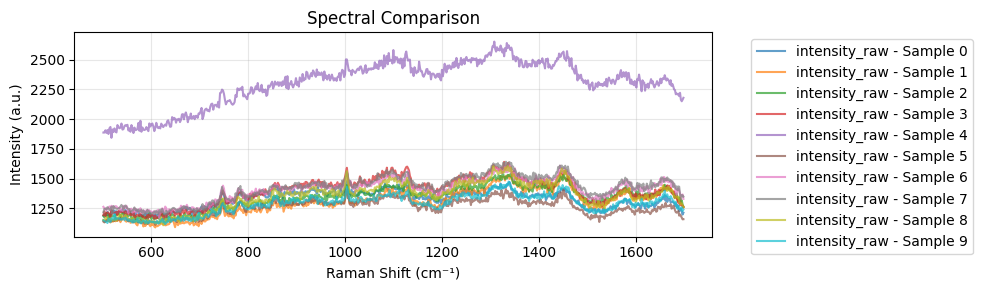

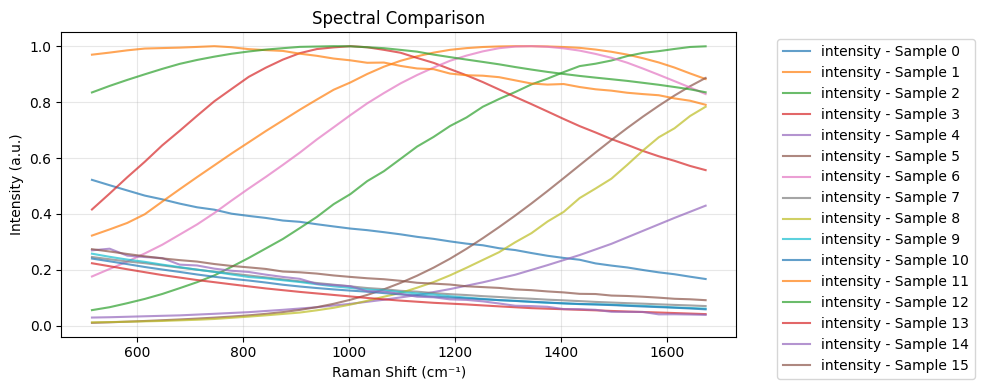

In [3]:
# Load real fluorophore spectra
fluorophore_ds = load_fluorophores(
    './data/fluorophores/uniform.csv',
    laser_nm=532.0,
    crop_range=(500, 1700))
fluorophore_ds

# # Load ATCC Raman spectra as basis for synthetic data
atcc_dataset = load_data("../RamaN2V/data/ATCC/")
atcc_xr = atcc_dataset.to_xarray(
    crop=(500, 1700),
    remove_outliers=True,
    remove_incomplete=True,
    despike=True,
)

print(f"Fluorophore dataset: {fluorophore_ds.dims}")

print(f"Raman dataset: {atcc_xr.dims}")
      
compare_spectra(data = [convert_to_spectral_data(atcc_xr.sel(integration_time='15s'), intensity_var='intensity_raw')], width=10, height=3,separate_samples=False, n_samples=10)
compare_spectra(data = [convert_to_spectral_data(fluorophore_ds, intensity_var='intensity')], separate_samples=False,width=10, height=4, n_samples=fluorophore_ds.sample.size)



(<Figure size 3000x2000 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

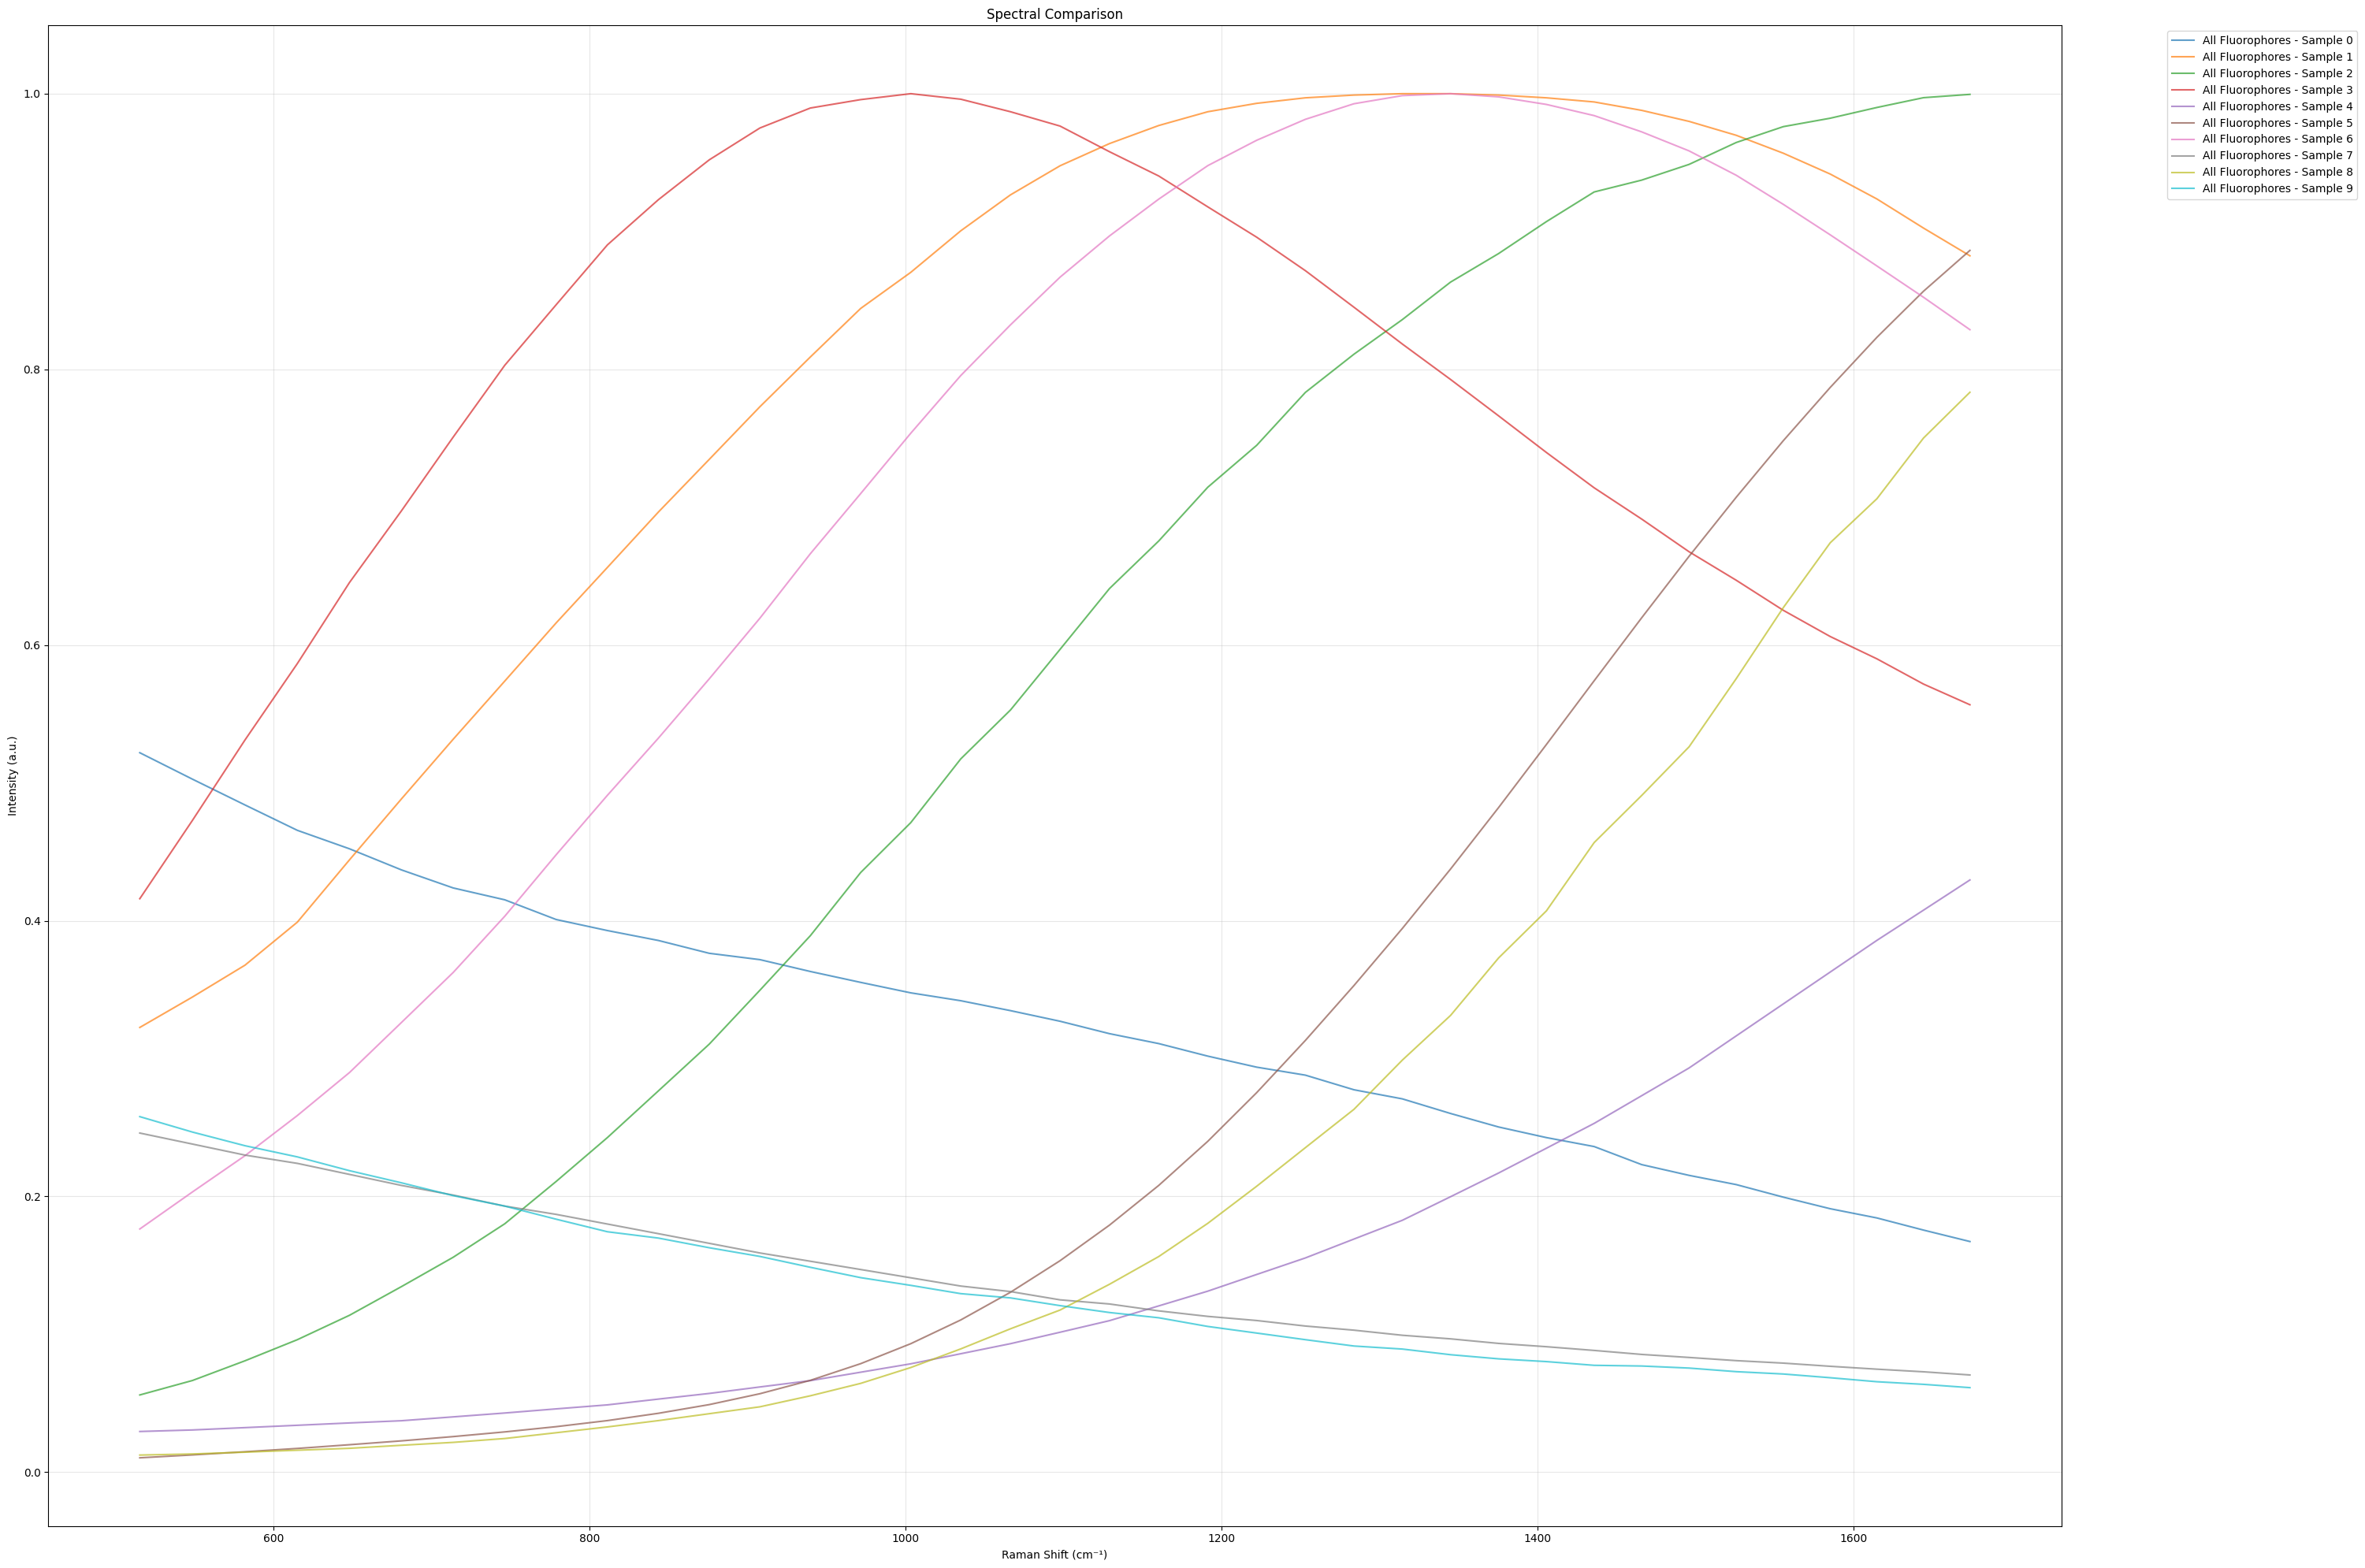

In [4]:
# We can create a container from the data easily
fluorophore_container = SpectralData(
    intensities=fluorophore_ds.intensity.values,  # shape (n_samples, n_wavenumbers)
    wavenumbers=fluorophore_ds.wavenumber.values,   # shape (n_wavenumbers,)
    label="All Fluorophores"
)

compare_spectra(data=[fluorophore_container], n_samples=10)

## 3. Generate Synthetic Bleaching Dataset

In [5]:
config = SyntheticConfig(
    n_samples=100,
    bleaching_interval=0.1,         # 0.1s between frames
    bleaching_max_time=15.0,        # 15s total (151 frames)
    integration_times=["15s"],
    decay_rate_min=0.2,            # slowest: τ = 20s
    decay_rate_max=4,               # fastest: τ = 0.2s
    n_fluorophores=3,
    use_polynomial_fluorophores=True,
    use_shared_bases=False,
    fluorophore_polynomial_degree=3,
    decay_sampling="log_uniform",
    poisson_noise_scale=0.01,
    gaussian_noise_scale=0.03,
    fr_ratio_min=4.0,
    fr_ratio_max=5.0,
    fluorophore_weight_min=0.5,
    fluorophore_weight_max=2.0,
    noise_type="gaussian",
    interpolation_method="spline",
    seed=8
)

generator = SyntheticBleachingDataset(config, atcc_xr, fluorophore_xr=fluorophore_ds)
synthetic_ds = generator.generate()

# Extract key arrays
time_points_full = synthetic_ds.bleaching_time.values
wavenumbers_arr = synthetic_ds.wavenumber.values  # May be 2D (per-sample) or 1D
n_timepoints = len(time_points_full)
n_wavenumbers = wavenumbers_arr.shape[-1]  # Last dimension is always wavenumber count

print(f"Dataset: {synthetic_ds.dims}")
print(f"Time range: {time_points_full[0]:.1f}s - {time_points_full[-1]:.1f}s ({n_timepoints} frames)")
print(f"Wavenumber shape: {wavenumbers_arr.shape} ({n_wavenumbers} points per sample)")

print(synthetic_ds.fluorophore_name.values)

Bleaching time points: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15. ]

Using integration time '15s' for Raman extraction
Available samples: 1830
Wavenumber axis: per-sample (shape (1830, 630))

Generating 100 synthetic samples...
Sampling real fluorophore spectra...
Using polynom

/Users/tom/Developments/Raman/flogen/ramanlib/bleaching/visualize.py:764: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


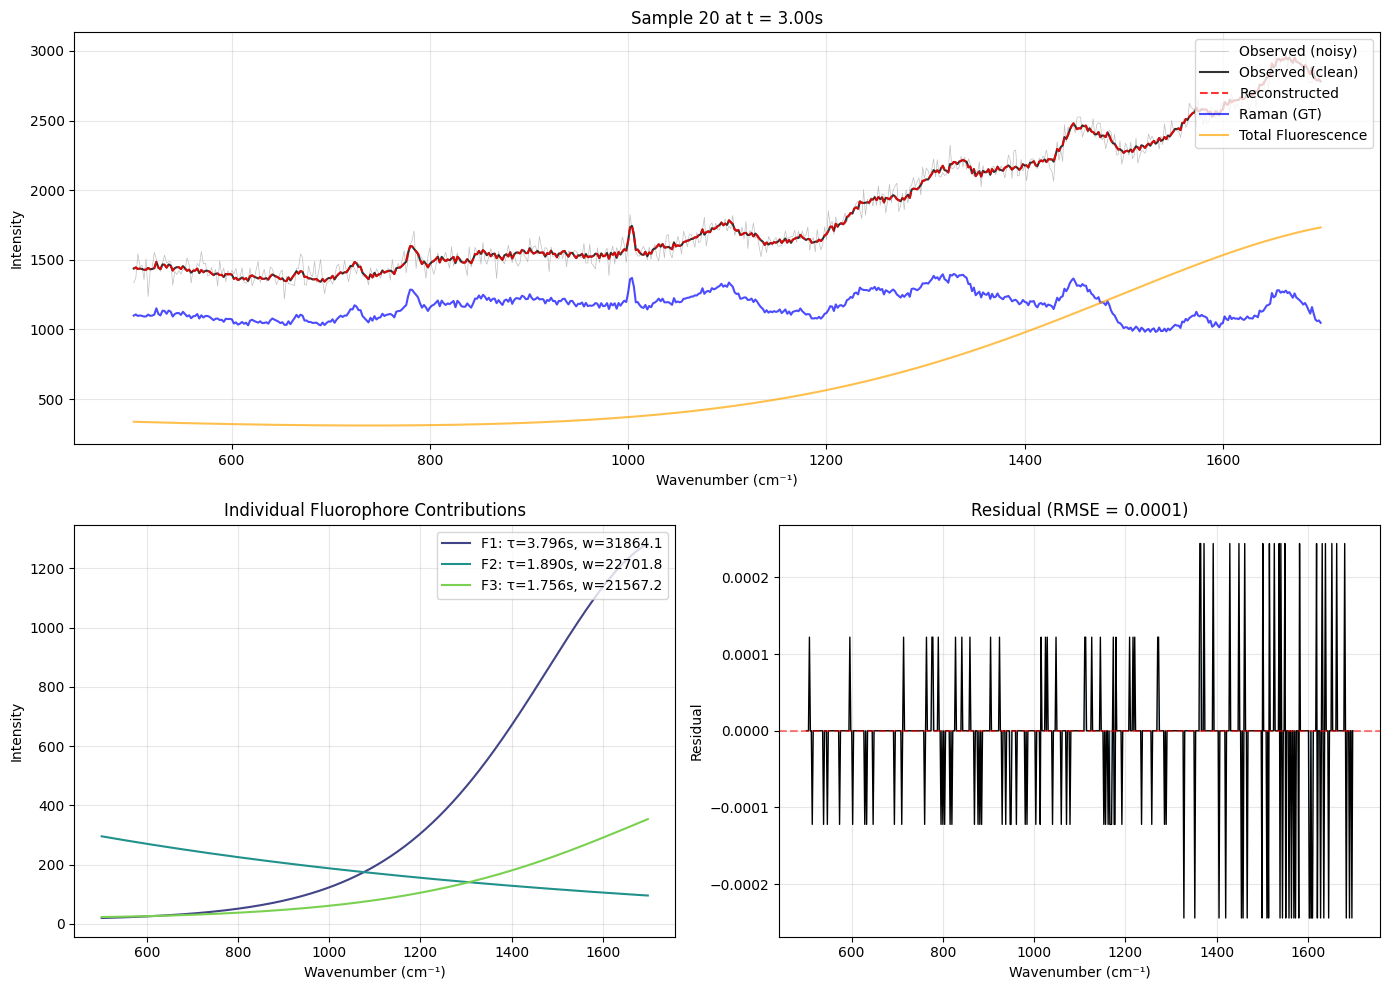

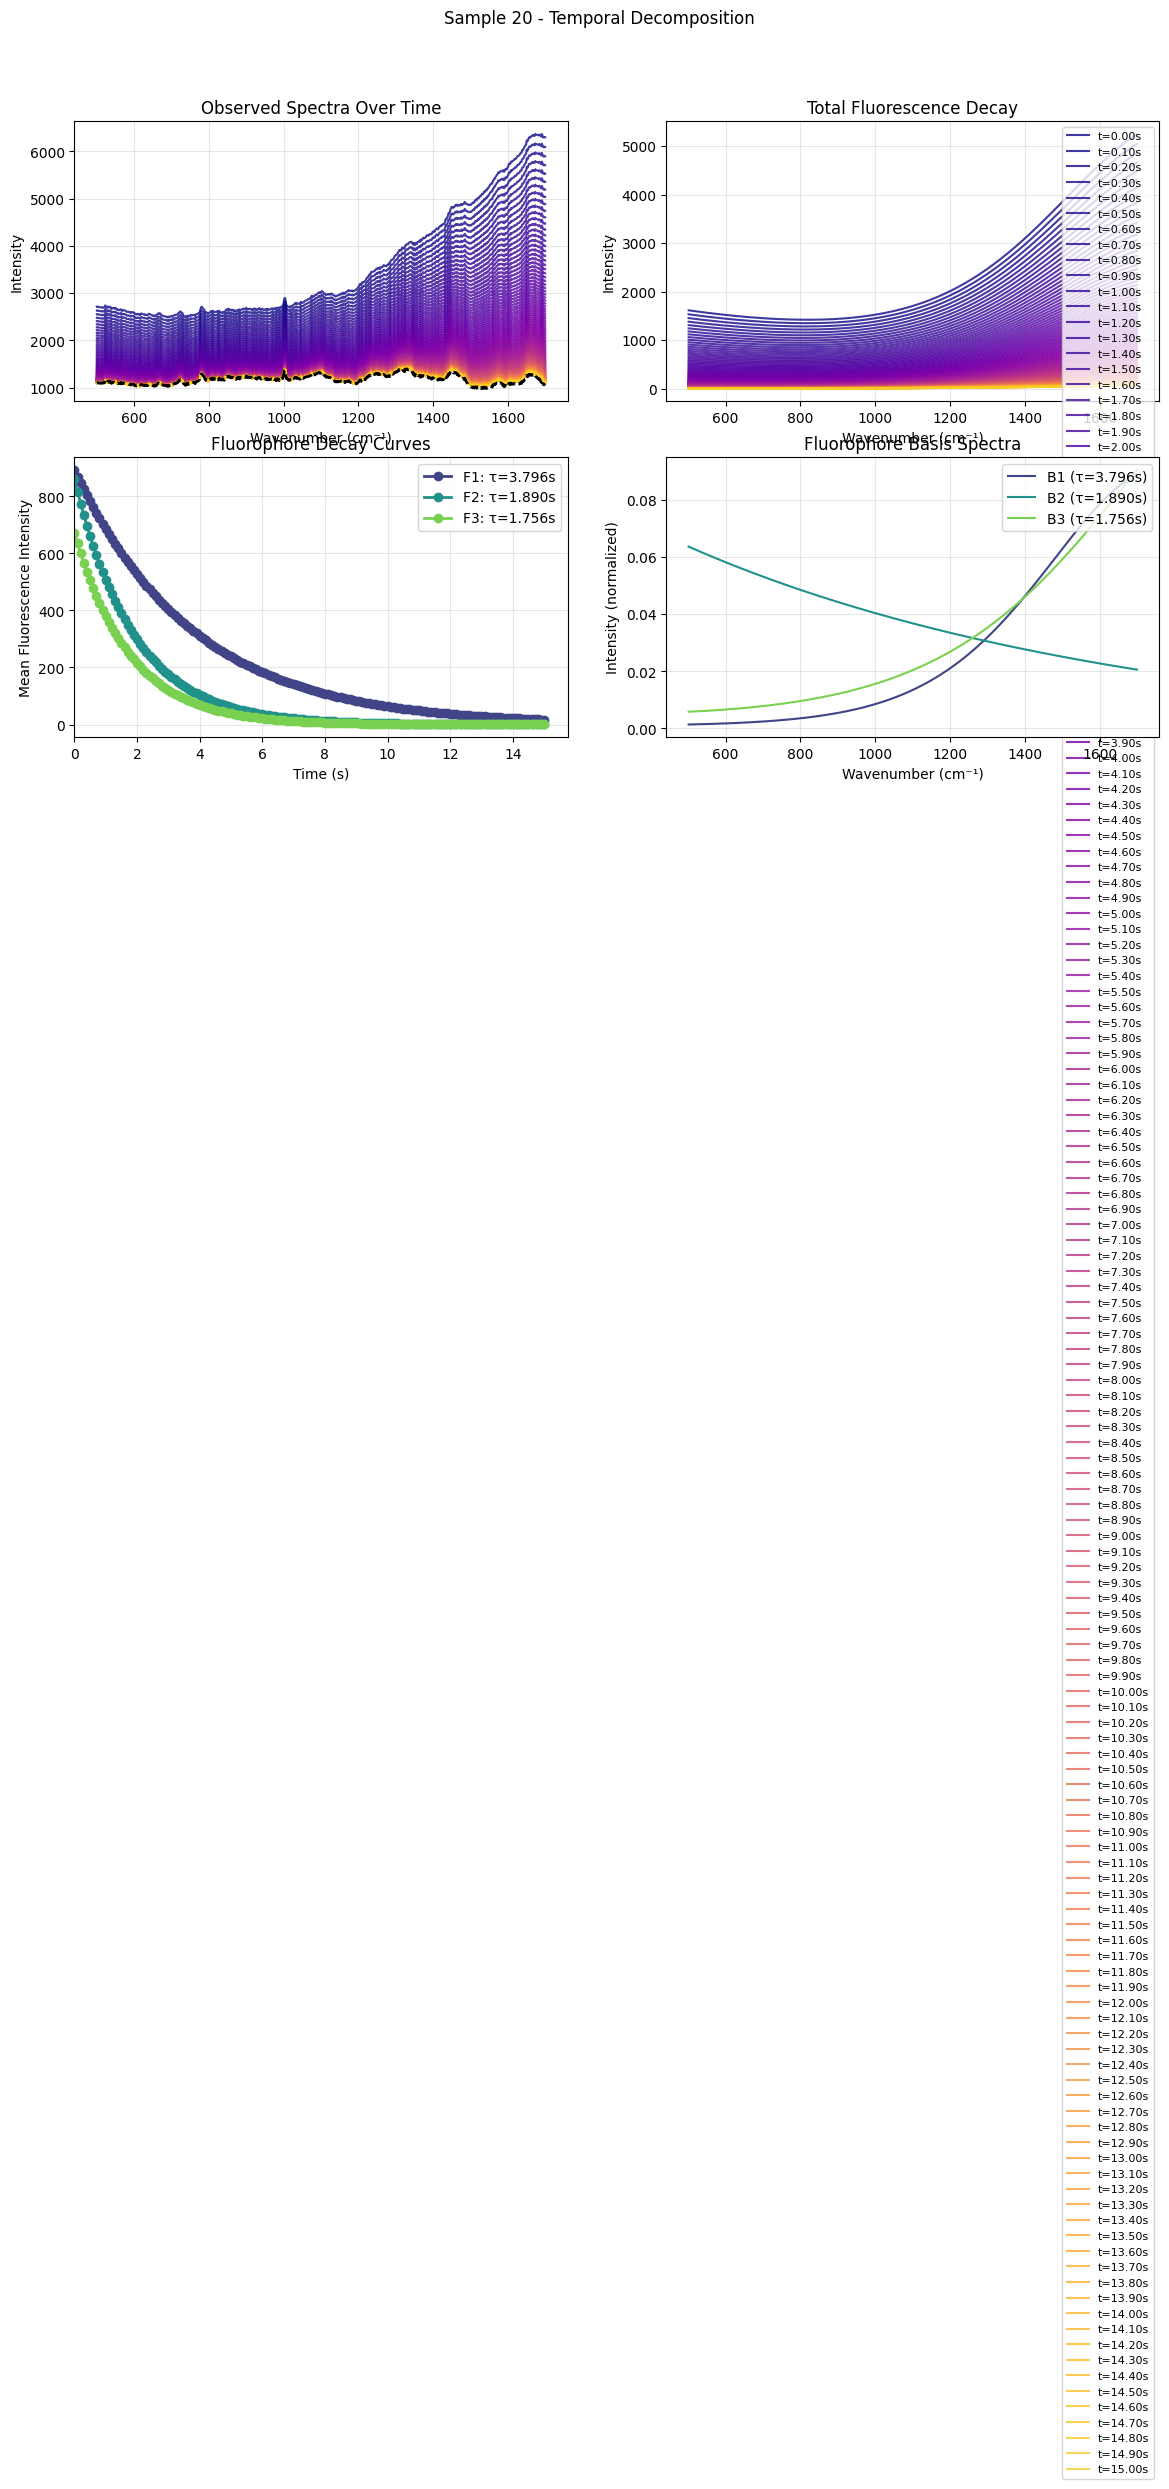

In [6]:
# Visualise Generated Data
sample = 20

plot_decomposition(synthetic_ds, sample, 3)

plot_temporal_decomposition(synthetic_ds, sample)

visualize_data_3d(
    data=synthetic_ds.sel(sample=sample).intensity_raw.values,
    time_values=synthetic_ds.bleaching_time.values,
    wavenumbers=synthetic_ds.sel(sample=1).wavenumber.values,
)

In [91]:
print(synthetic_ds.sel(sample=sample).fluorophore_name.values)

['DsRed-Max em' 'dsFP483 em' 'mKeima (pH7.4) em']


In [12]:
import importlib

# import ramanlib.bleaching.utils.decomposition as decomposition

# importlib.reload(decomposition)
from ramanlib.bleaching.models import fit_physics_model

n_times = 60
sample = 10

print(f"Fitting physics-based model to sample {sample} with {n_times} time points")

print(f"GT Values:")
print(f"Tau: {1/(synthetic_ds.isel(sample=sample).decay_rates_gt.values)}")
print(f"Abundances: {synthetic_ds.isel(sample=sample).abundances_gt.values}")

sample_spectra = SpectralData(
    intensities=synthetic_ds.sel(sample=sample).intensity_raw.values,
    wavenumbers=synthetic_ds.sel(sample=sample).wavenumber.values,
    time_values=synthetic_ds.bleaching_time.values,
    label=synthetic_ds.sel(sample=sample).fluorophore_name.values
)
print(sample)
# print(
#     f"Time series shape: {time_series.shape}, Wavenumbers: {wavenumbers_arr.shape}, Time values: {time_values.shape}"
# )

device = "cuda" if torch.cuda.is_available() else "cpu"

# rates_calculator = decompose(
#     real_data_spectral[:n_times],
#     # time_points=synthetic_ds.sel(sample=sample).bleaching_time.values[:n_times],
#     # wavenumbers=synthetic_ds.sel(sample=sample).wavenumber.values,
#     n_fluorophores=3,
#     rate_bounds=(0.01, 15),  # Adjusted bounds to match synthetic data better
#     maxiter=50,
#     verbose=False,
#     use_polynomial_bases=False
# )

# print(f"Initial estimated rates: {rates_calculator.rates}")
result_flex = decompose(
    sample_spectra[:n_times],
    n_fluorophores=3,
    maxiter=100,
    verbose=False,
    use_polynomial_bases=False  # Fast optimization
)
model, history = fit_physics_model(
    data=sample_spectra,
    # initial_bases=synthetic_ds.sel(sample=sample).fluorophore_bases_gt.values,
    # initial_rates=synthetic_ds.sel(sample=sample).decay_rates_gt.values,
    n_epochs=60000,
    lr=0.0005,
    n_fluorophores=3,
    basis_type="polynomial",
    polynomial_degree=3,
    min_decay_rate=0.01,
    first_times=n_times,
    device=device,
)

Fitting physics-based model to sample 10 with 60 time points
GT Values:
Tau: [0.7096928  0.2915115  0.36131713]
Abundances: [90243.46  79757.55  23464.494]
10
Best rates shape: (3,)
(3,)
Shapes: data torch.Size([60, 630]), time torch.Size([60]), wn torch.Size([630])


/Users/tom/Developments/Raman/flogen/ramanlib/bleaching/models.py:149: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/tom/Developments/Raman/flogen/ramanlib/bleaching/models.py:153: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1000/60000: loss=7.320e+06, τ=[1.9494776 1.6176068 1.9048016]
Epoch 2000/60000: loss=7.312e+06, τ=[3.8634706 3.2795417 3.7866824]
Epoch 3000/60000: loss=7.293e+06, τ=[7.5120068 6.546891  7.3864512]
Epoch 4000/60000: loss=7.252e+06, τ=[13.582514 12.086551 13.389379]
Epoch 5000/60000: loss=7.162e+06, τ=[22.645504 20.51523  22.372929]
Epoch 6000/60000: loss=6.971e+06, τ=[34.64753  31.949429 34.306213]
Epoch 7000/60000: loss=6.582e+06, τ=[48.386925 45.425774 48.01747 ]
Epoch 8000/60000: loss=5.839e+06, τ=[61.70302 58.8946  61.3569 ]
Epoch 9000/60000: loss=4.606e+06, τ=[72.485115 70.10614  72.19499 ]
Epoch 10000/60000: loss=3.126e+06, τ=[79.27706  77.314606 79.03923 ]
Epoch 11000/60000: loss=2.306e+06, τ=[78.84887  76.86997  78.608574]
Epoch 12000/60000: loss=2.206e+06, τ=[61.41898 58.69322 61.08189]
Epoch 13000/60000: loss=2.192e+06, τ=[39.174618 36.52704  38.840157]
Epoch 14000/60000: loss=2.157e+06, τ=[21.297245 19.467638 21.062355]
Epoch 15000/60000: loss=2.010e+06, τ=[9.911471  8

Shapes: (630,) (3, 630) (3,) (3,) (151,)


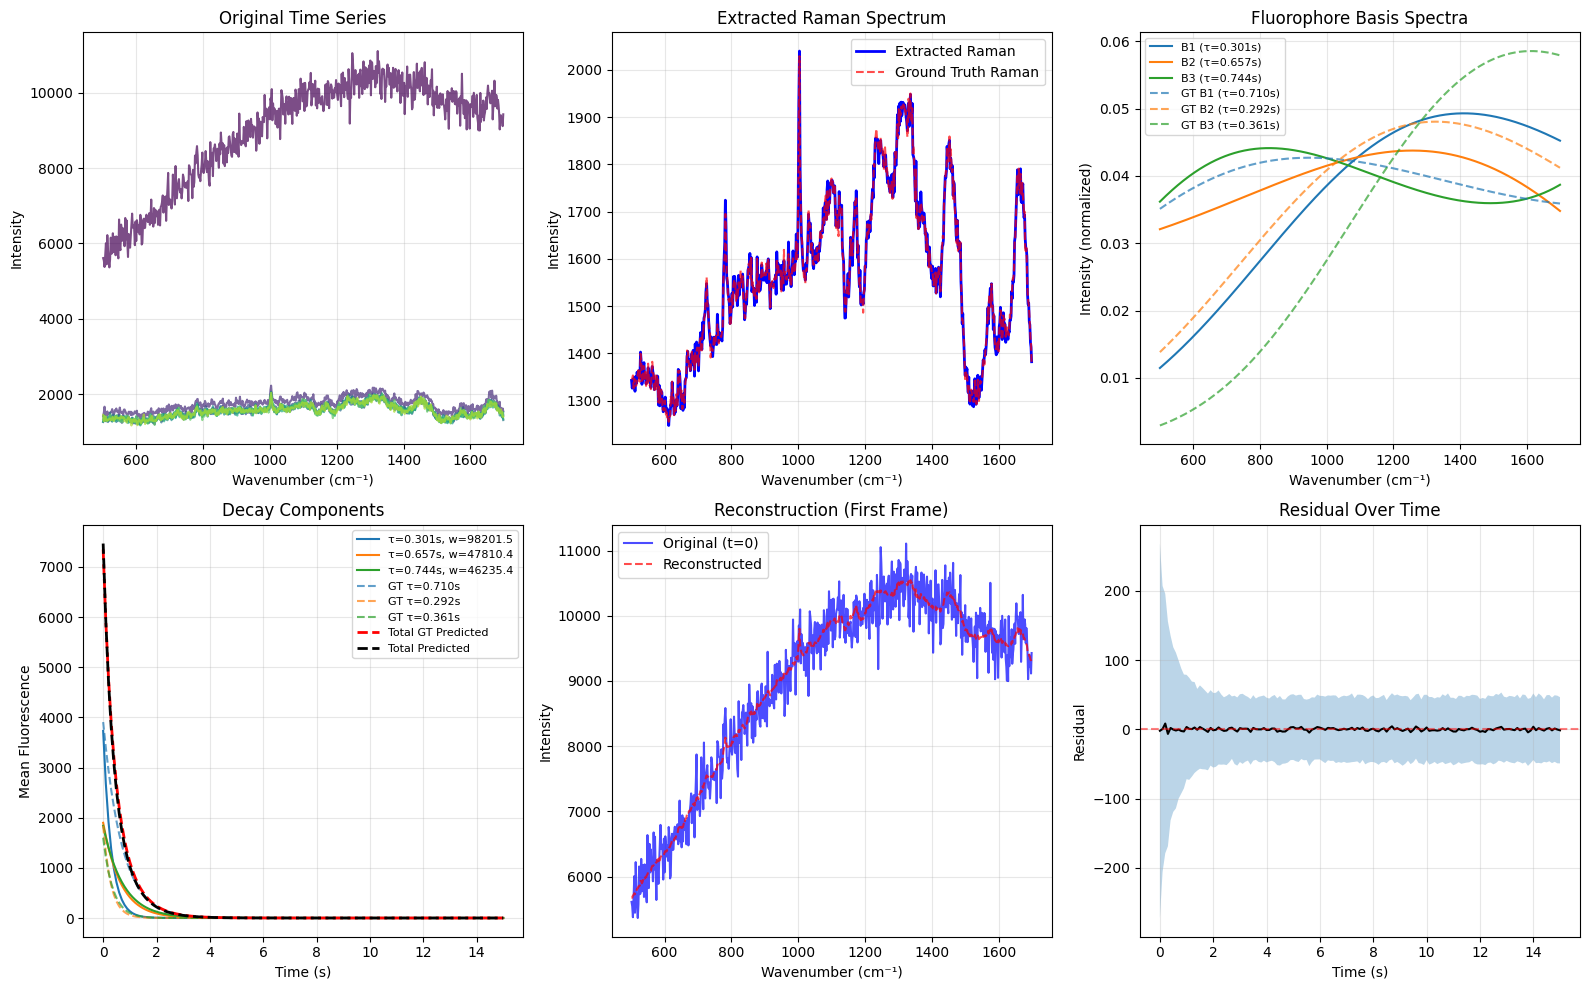


Reconstruction MSE: 3904.538786
First times reconstruction MSE: 14366.97221469476)
Raman correlation with reference: 0.9981
Time constants (τ): [0.30137345 0.656748   0.7436768 ]
Abundances (w): [98201.5   47810.41  46235.438]
   Fluorophore correlations: [0.98839035 0.87834408 0.77975642]
3 16
(3, 16)
['mKillerOrange em' 'DsRed em' 'TagRFP-T em']


0         1                2
0  LSSmOrange em  DsRed em  KillerOrange em

In [13]:
decomposition = model.get_decomposition()
# print(decomposition.raman.intensities.shape)
# print(decomposition.fluorophore_spectra.intensities.shape)
# Visualise results
        # decomposition: Dictionary with keys:
        #     - 'raman': Extracted Raman spectrum (n_wavenumbers,)
        #     - 'fluorophore_bases': Fluorophore bases (n_fluorophores, n_wavenumbers)
        #     - 'abundances': Abundances (n_fluorophores,)
        #     - 'rates' or 'decay_rates': Decay rates (n_fluorophores,
# print(sample_spectra.intensities.mean())
# print(synthetic_ds.sel(sample=sample).raman_gt.values.mean())
# print(model.fluorophore_bases.cpu().detach().numpy().mean())
# print(model.raman_spectrum.cpu().detach().numpy().mean())
# print(synthetic_ds.fluorophore_bases_gt.values[0].mean())


# print(model().mean())
visualise_decomposition(
    data=sample_spectra,
    decomposition=decomposition,
    reference_raman=synthetic_ds.sel(sample=sample).raman_gt.values,
    reference_bases=synthetic_ds.isel(sample=sample).fluorophore_bases_gt.values,
    reference_rates=synthetic_ds.isel(sample=sample).decay_rates_gt.values,
)

  
predicted_fluorophore_spectra = convert_to_spectral_data(decomposition.fluorophore_spectra.intensities, decomposition.fluorophore_spectra.wavenumbers)
fluorophore_spectra = convert_to_spectral_data(data=fluorophore_ds.intensity.values,wavenumbers=fluorophore_ds.wavenumber.values, label=fluorophore_ds.fluorophore_name.values)

flourophore_corrs= get_fluorophore_corrs(predicted_fluorophore_spectra,  fluorophore_spectra)

max_flourophore_corrs= flourophore_corrs.idxmax(axis=1).to_frame().T


# corr_matrix = pd.DataFrame(data=flourophore_corrs, columns=fluorophore_spectra.label)
# print(sample_spectra.label)

# fig, ax = plt.subplots(figsize=(19, 15))
# ax.matshow(corr_matrix)
# ax.set_xticks(np.arange(0, 16, 1.0), labels=fluorophore_spectra.label,rotation=45, ha="right")
# ax.set_xticklabels(fluorophore_spectra.label)

# plt.xticks(labels=corr_matrix.index.values, fontsize=14, rotation=45)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Fluorophore Correlation Matrix', fontsize=16);
# corr_matrix
# print(flourophore_corrs.shape)
# from decomposition import visualise_decomposition_3d
# visualise_decomposition_3d(model, time_series, wavenumbers_arr, time_values)




# # compare predicted vs actual fluorophore spectra
# predicted_bases = model.fluorophore_bases.cpu().detach().numpy()  # (n_fluorophores, n_wavenumbers)
# actual_bases = synthetic_ds.isel(sample=sample).fluorophore_bases_gt.values  # (n_fluorophores, n_wavenumbers)
# pu.compare_spectra(
#     [pu.convert_to_spectral_data(predicted_bases, wavenumbers=wn_real),
#      pu.convert_to_spectral_data(actual_bases, wavenumbers=wn_real) ],
#     titles=["Predicted Fluorophore Bases", "Actual Fluorophore Bases"],
#     n_samples=3,
#     height=3,
#     separate_samples=True,
#     width=10,
# )

# actual_bases = synthetic_ds.isel(sample=sample).fluorophore_bases_gt.values

# visualize_decomposition_3d(data=synthetic_ds.sel(sample=sample).intensity_raw.values, decomposition=model.get_decomposition(), time_values=synthetic_ds.bleaching_time.values, wavenumbers=synthetic_ds.sel(sample=sample).wavenumber.values
print(sample_spectra.label)
max_flourophore_corrs

# Decomposition Method


 Find rates with flexible bases (fast)...
Best rates shape: (3,)
(3,)
   Rates found: [1.86425288 4.29576682 0.91149677]
   Abundances found: [1. 1. 1.]
   Time constants: [0.53640792 0.23278731 1.09709659]
   MSE: 5011.62
   Polynomial-constrained spectra computed
   Polynomial coeffs shape: (3, 4)
Shapes: (630,) (3, 630) (3,) (3,) (151,)


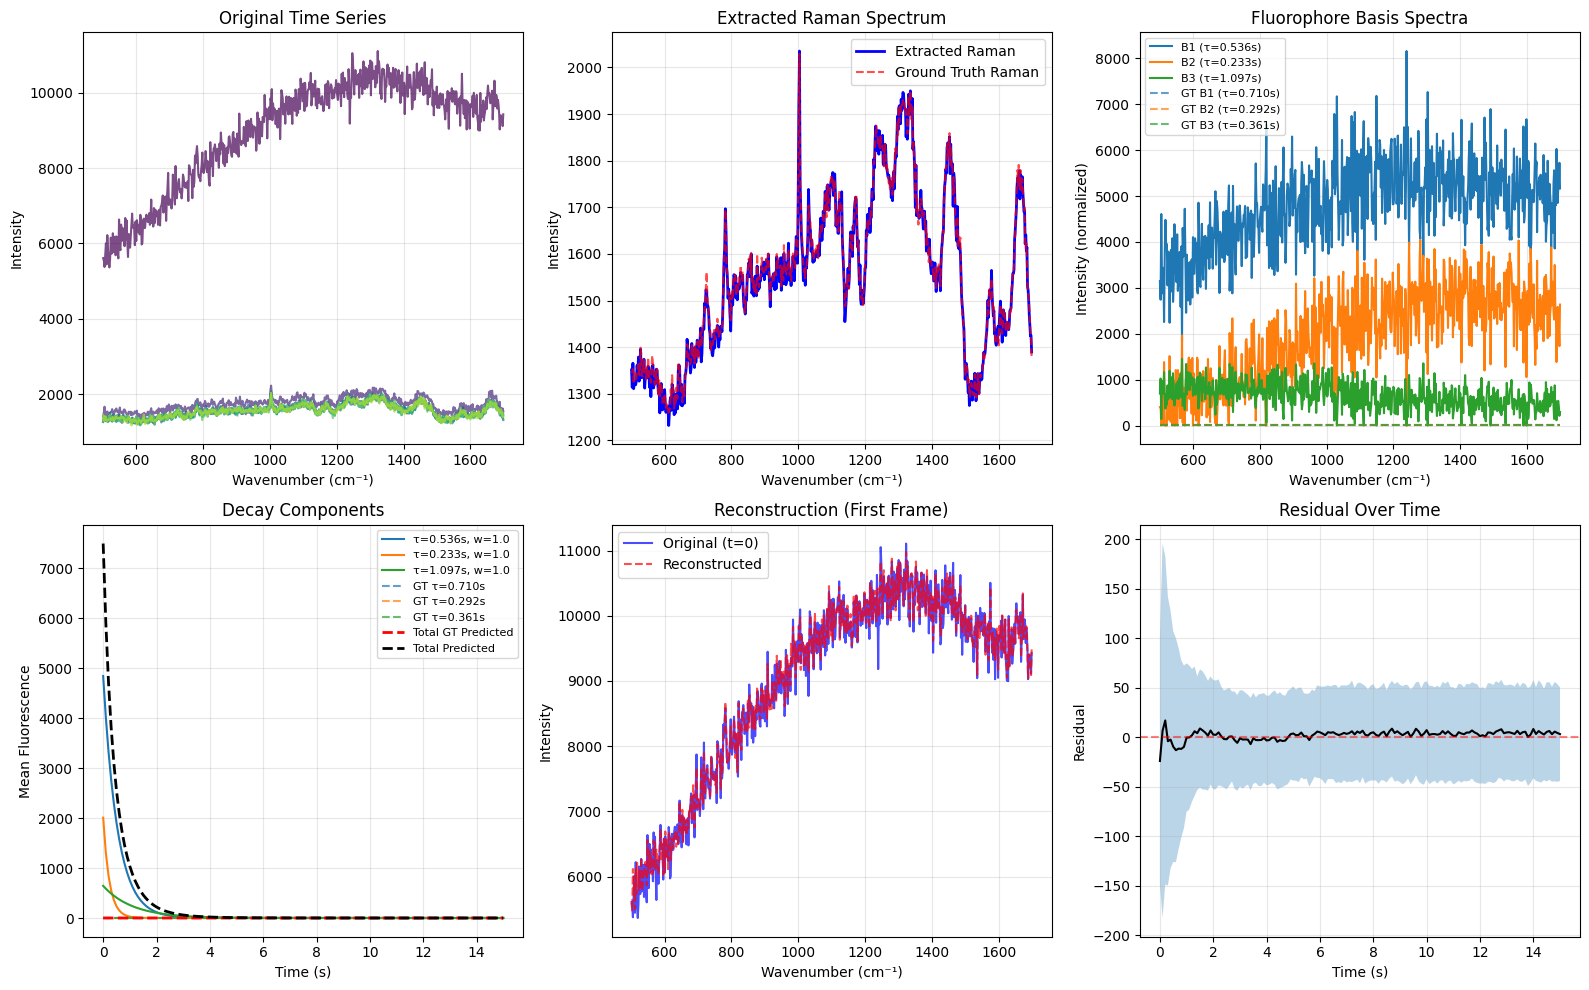


Reconstruction MSE: 3434.764424
First times reconstruction MSE: 10515.306481451176)
Raman correlation with reference: 0.9969
Time constants (τ): [0.53640792 0.23278731 1.09709659]
Abundances (w): [1. 1. 1.]
   Fluorophore correlations: [0.66418062 0.77335686 0.21677099]
Shapes: (630,) (3, 630) (3,) (3,) (151,)


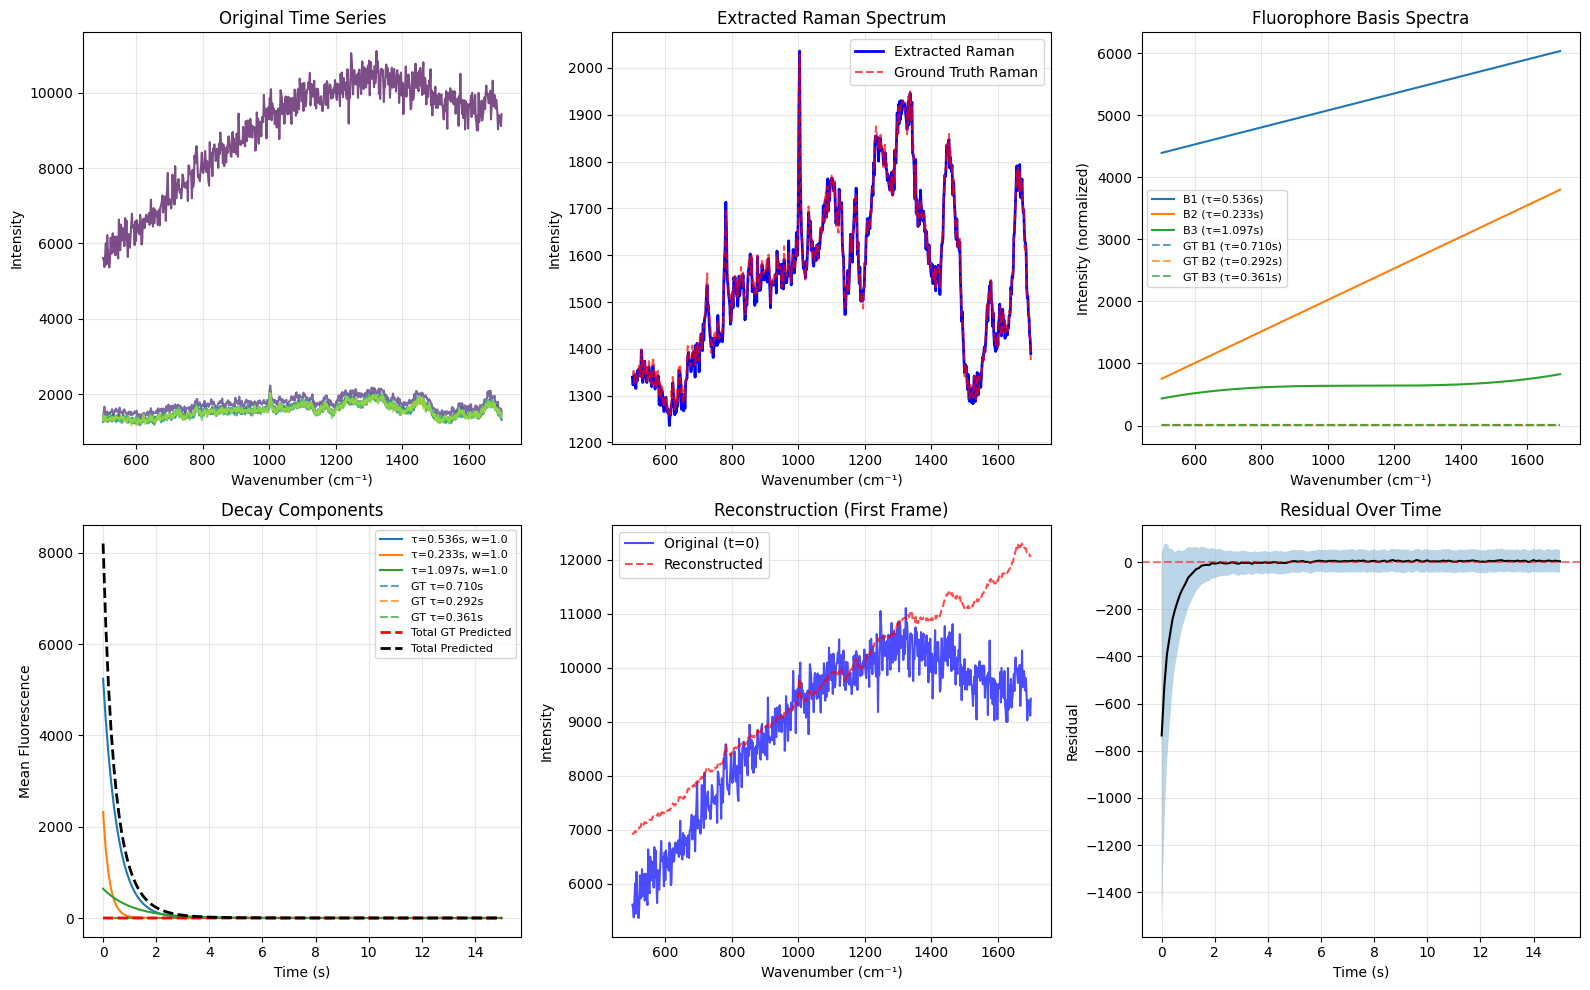


Reconstruction MSE: 21475.062985
First times reconstruction MSE: 146622.57143071084)
Raman correlation with reference: 0.9980
Time constants (τ): [0.53640792 0.23278731 1.09709659]
Abundances (w): [1. 1. 1.]
   Fluorophore correlations: [0.98736943 0.98736943 0.85112876]
3 16
(3, 16)
3 16
(3, 16)
['mKillerOrange em' 'DsRed em' 'TagRFP-T em']
   Citrine em  DsRed em  TagRFP-T em  mOrange em  mKeima (pH7.4) em  \
0   -0.997025  0.850226     0.987368   -0.105172           0.937324   
1   -0.996963  0.850407     0.986501   -0.102416           0.937361   
2   -0.935522  0.762190     0.847852    0.043465           0.868799   

   mScarlet em  LSSmOrange em  mTurquoise2 em  DsRed-Max em  WasCFP em  \
0     0.938986       0.876565       -0.980358      0.926250  -0.975239   
1     0.937617       0.876092       -0.980326      0.925430  -0.975243   
2     0.836748       0.745245       -0.901836      0.843203  -0.899295   

   NowGFP em  KillerOrange em  mKillerOrange em  TurboGFP em  GFP (S65T) 

In [14]:
# Demonstrate polynomial constraint vs flexible bases
from ramanlib.bleaching.physics import reconstruct_time_series


# (Differential eveolution to obtain the rates. Once we have rates it is linear and we can solve with Least Squares
print("\n Find rates with flexible bases (fast)...")
result_flex = decompose(
    sample_spectra[:n_times],
    n_fluorophores=3,
    maxiter=100,
    verbose=False,
    use_polynomial_bases=False  # Fast optimization
)
print(f"   Rates found: {result_flex.rates}")
print(f"   Abundances found: {result_flex.abundances}")
print(f"   Time constants: {1/result_flex.rates}")
print(f"   MSE: {result_flex.mse:.2f}")

# STAGE 2: Re-solve spectra with polynomial constraint using those rates) (NNLS) as problem is now once again linear. When trying to solve jointly before it took too long
from ramanlib.bleaching import solve_spectra_with_polynomial_bases

result_poly = solve_spectra_with_polynomial_bases(
    data=sample_spectra[:n_times],
    decay_rates=result_flex.rates,  # Use rates from Stage 1
    polynomial_degree=3
)
print(f"   Polynomial-constrained spectra computed")
print(f"   Polynomial coeffs shape: {result_poly.log_polynomial_coeffs.shape}")

# Compute MSE for polynomial solution

# mse_poly = np.mean((real_data_spectral.intensities - reconstruct_time_series(result_poly.raman.intensities, result_poly.fluorophore_spectra.intensities, np.ones_like(result_poly.rates), result_poly.rates, real_data_spectral.time_values))**2)
# print(f"   MSE: {mse_poly:.2f}")

# # Sharpness analysis - higher = sharper, more peak-like
# def compute_sharpness(spectrum):
#     """Higher values indicate sharper, more peak-like spectra"""
#     return np.std(np.diff(spectrum, n=2))


# print("SHARPNESS ANALYSIS (higher = more peaks)")


# poly_raman_sharp = compute_sharpness(raman_poly.intensities)
# poly_fluor_sharps = [compute_sharpness(fluor_poly.intensities[k]) 
#                      for k in range(len(result_flex.rates))]

# flex_raman_sharp = compute_sharpness(result_flex.raman.intensities)
# flex_fluor_sharps = [compute_sharpness(result_flex.fluorophore_spectra.intensities[k]) 
#                      for k in range(len(result_flex.rates))]


visualise_decomposition(
    data=sample_spectra,
    decomposition=result_flex,
    reference_raman=synthetic_ds.sel(sample=sample).raman_gt.values,
    reference_bases=synthetic_ds.isel(sample=sample).fluorophore_bases_gt.values,
    reference_rates=synthetic_ds.isel(sample=sample).decay_rates_gt.values,
    normalise=True
)

visualise_decomposition(
    data=sample_spectra,
    decomposition=result_poly,
    reference_raman=synthetic_ds.sel(sample=sample).raman_gt.values,
    reference_bases=synthetic_ds.isel(sample=sample).fluorophore_bases_gt.values,
    reference_rates=synthetic_ds.isel(sample=sample).decay_rates_gt.values,
)

spectra_free = convert_to_spectral_data(result_flex.fluorophore_spectra.intensities, result_flex.fluorophore_spectra.wavenumbers)

spectra_poly = convert_to_spectral_data(result_poly.fluorophore_spectra.intensities, result_poly.fluorophore_spectra.wavenumbers)

poly_corrs= get_fluorophore_corrs(spectra_poly,  fluorophore_spectra)
free_corrs = get_fluorophore_corrs(spectra_free,fluorophore_spectra)

max_free_corrs = free_corrs.idxmax(axis=1).to_frame().T
max_poly_corrs= poly_corrs.idxmax(axis=1).to_frame().T

print(sample_spectra.label)
print(poly_corrs)
print(max_poly_corrs)

## Polynomial Constraint Test on Synthetic Data (with Ground Truth)

In [ ]:
# Evaluate decomposition on synthetic data with known ground truth
# Note: Synthetic data has slow decay components (τ up to 20s), so more frames are needed

n_test_samples = min(20, config.n_samples)
n_frames_list = [5, 10, 15, 25, 35]  # Extended range for slow decay

results_synthetic = {n: {'corr_raman': [], 'corr_rates': [], 'mse': []} for n in n_frames_list}

print(f"Evaluating decomposition on {n_test_samples} synthetic samples...")
print(f"Testing frame counts: {n_frames_list}")

for sample_idx in range(n_test_samples):
    # Extract sample data using correct variable names
    Y_sample = synthetic_ds.intensity_clean.values[sample_idx, :, :]  # (T, W)
    raman_true = synthetic_ds.raman_gt.values[sample_idx, :]  # (W,)
    rates_true = synthetic_ds.decay_rates_gt.values[sample_idx, :]  # (K,)
    
    for n_frames in n_frames_list:
        # Use first n_frames
        Y_subset = Y_sample[:n_frames, :]
        t_subset = time_points_full[:n_frames]
        
        # Run decomposition
        result = decompose(Y_subset, t_subset, n_fluorophores=config.n_fluorophores, maxiter=50, use_polynomial_bases=False, verbose=False)
        
        # Extract raman intensities (result.raman is now SpectralData)
        raman_pred = result.raman.intensities if hasattr(result.raman, 'intensities') else result.raman
        
        # Evaluate Raman recovery
        corr_raman = np.corrcoef(raman_pred, raman_true)[0, 1]
        results_synthetic[n_frames]['corr_raman'].append(corr_raman)
        
        # Evaluate rate recovery (sort both for comparison)
        rates_pred_sorted = np.sort(result.rates)
        rates_true_sorted = np.sort(rates_true)
        if len(rates_pred_sorted) == len(rates_true_sorted):
            corr_rates = np.corrcoef(rates_pred_sorted, rates_true_sorted)[0, 1]
        else:
            corr_rates = np.nan
        results_synthetic[n_frames]['corr_rates'].append(corr_rates)
        
        # MSE
        results_synthetic[n_frames]['mse'].append(result.mse)

# Print summary

print("SYNTHETIC DATA DECOMPOSITION RESULTS")

print(f"\n{'Frames':<10} {'Time (s)':<10} {'Raman Corr':>15} {'MSE':>15}")

for n_frames in n_frames_list:
    corr_r = np.mean(results_synthetic[n_frames]['corr_raman'])
    mse = np.mean(results_synthetic[n_frames]['mse'])
    time_s = n_frames * config.bleaching_interval
    print(f"{n_frames:<10} {time_s:<10.1f} {corr_r:>15.4f} {mse:>15.2f}")


Evaluating decomposition on 20 synthetic samples...
Testing frame counts: [5, 10, 15, 25, 35]
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates shape: (3,)
(3,)
Best rates

## DE For Real

Shapes: (554,) (3, 554) (3,) (3,) (128,)
Using last 20 frames average as reference Raman.


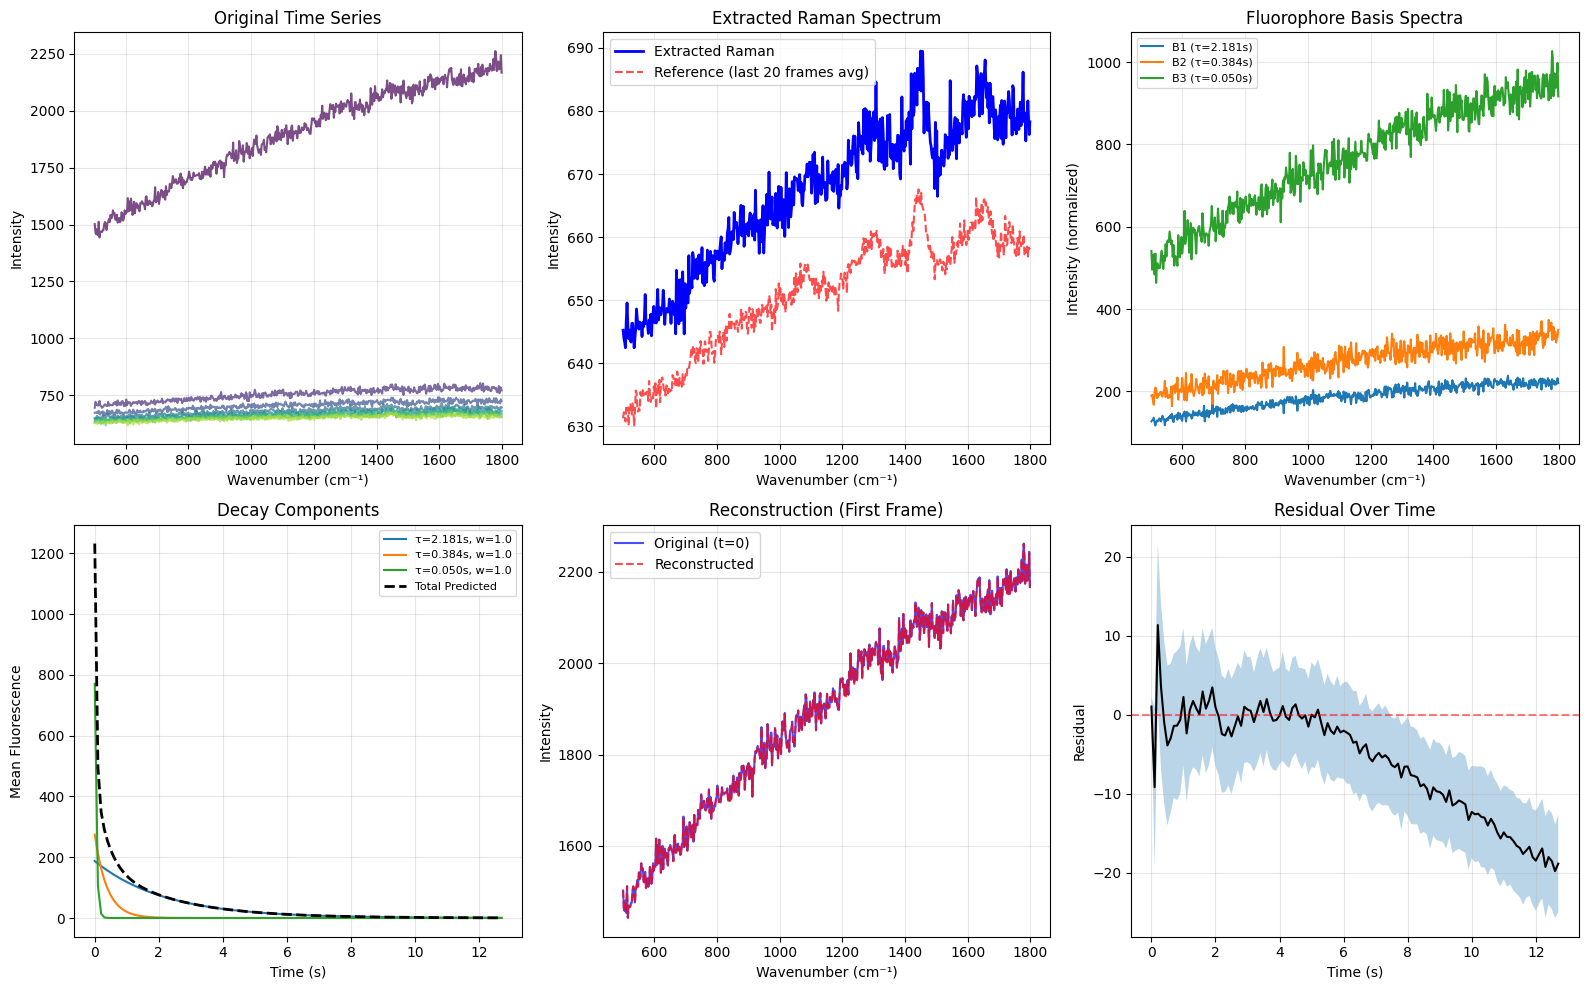


Reconstruction MSE: 125.315407
First times reconstruction MSE: 92.04097070818436)
Raman correlation with reference: 0.9731
Time constants (τ): [2.18145569 0.38367071 0.05000978]
Abundances (w): [1. 1. 1.]


(<Figure size 1600x1000 with 6 Axes>,
 array([[<Axes: title={'center': 'Original Time Series'}, xlabel='Wavenumber (cm⁻¹)', ylabel='Intensity'>,
         <Axes: title={'center': 'Extracted Raman Spectrum'}, xlabel='Wavenumber (cm⁻¹)', ylabel='Intensity'>,
         <Axes: title={'center': 'Fluorophore Basis Spectra'}, xlabel='Wavenumber (cm⁻¹)', ylabel='Intensity (normalized)'>],
        [<Axes: title={'center': 'Decay Components'}, xlabel='Time (s)', ylabel='Mean Fluorescence'>,
         <Axes: title={'center': 'Reconstruction (First Frame)'}, xlabel='Wavenumber (cm⁻¹)', ylabel='Intensity'>,
         <Axes: title={'center': 'Residual Over Time'}, xlabel='Time (s)', ylabel='Residual'>]],
       dtype=object))

In [20]:

n_times = 50
result_real = decompose(real_data_spectral, n_fluorophores=3, maxiter=100)
raman_128_ref = result_real.raman

result_example = decompose(real_data_spectral[:n_times], n_fluorophores=3, maxiter=100, verbose=False, polish=False, use_polynomial_bases=False)

visualise_decomposition(
    data=real_data_spectral,  # Now accepts SpectralData!
    decomposition=result_example,
)

# # Note: For synthetic data, we still extract arrays from xarray
# visualize_decomposition_3d(
#     data=,
#     decomposition=model.get_decomposition(),
#     time_values=synthetic_ds.bleaching_time.values,
#     wavenumbers=synthetic_ds.sel(sample=sample).wavenumber.values
# )

## DE For Synthetic

Ground Truth Decay Rates: [1.4090604 3.4303963 2.7676518]
Ground Truth Abundances: [90243.46  79757.55  23464.494]
Shapes: (630,) (3, 630) (3,) (3,) (151,)


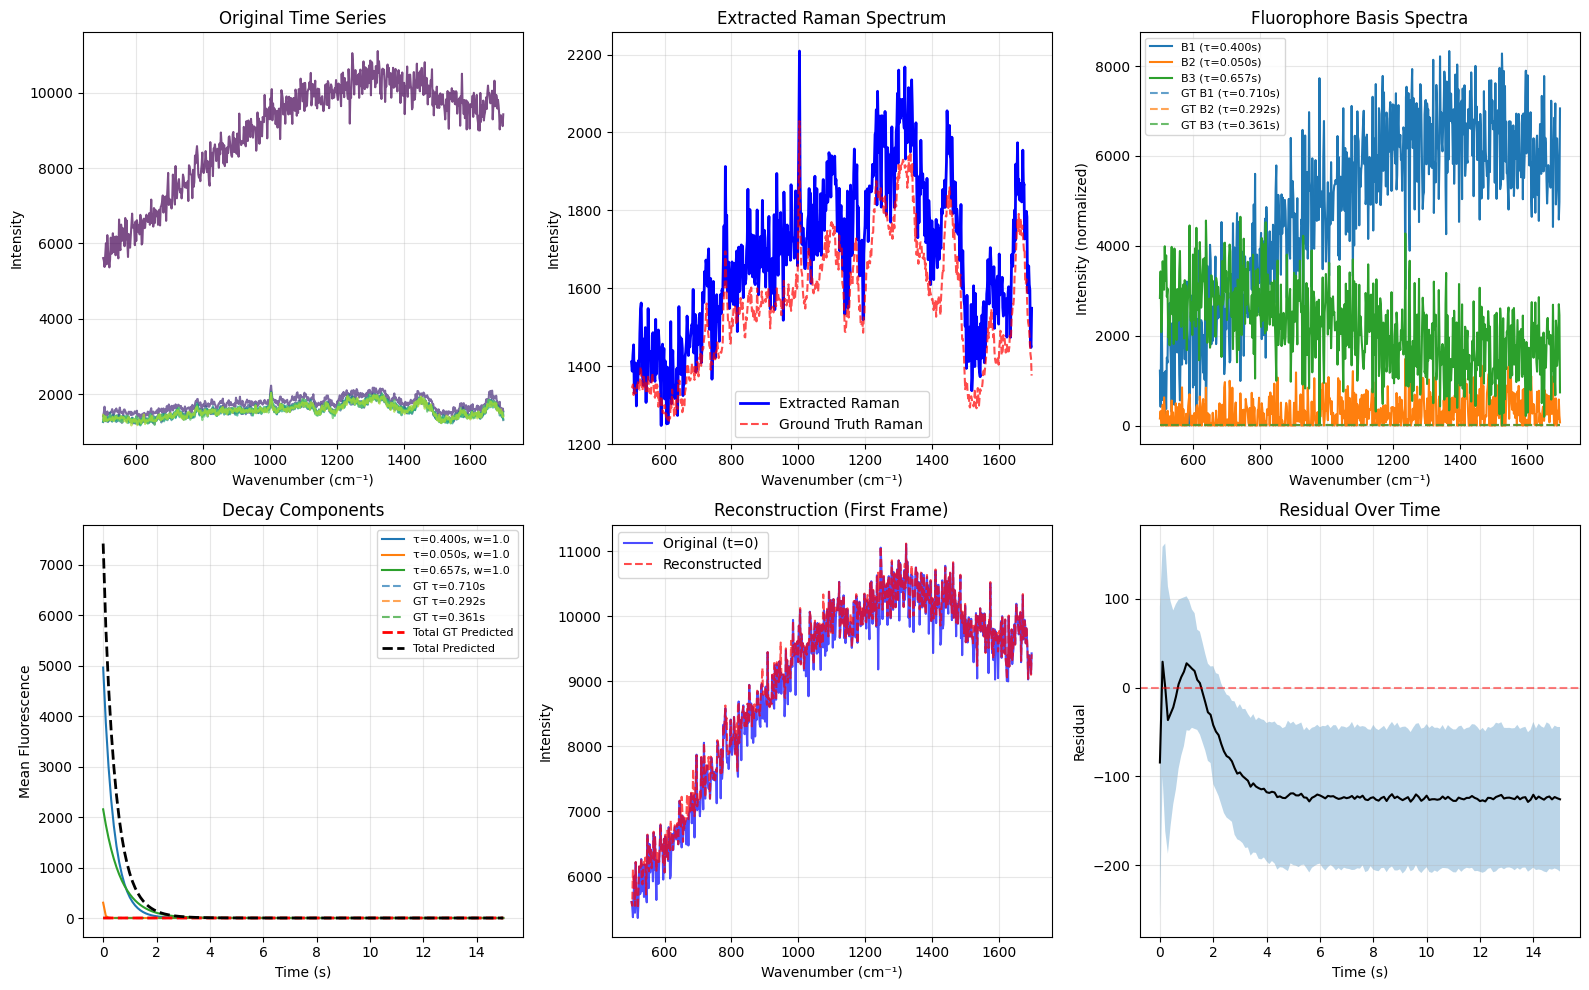


Reconstruction MSE: 19260.673396
First times reconstruction MSE: 10651.56031271242)
Raman correlation with reference: 0.9442
Time constants (τ): [0.40045897 0.05000452 0.6574477 ]
Abundances (w): [1. 1. 1.]
   Fluorophore correlations: [0.868965   0.21823031 0.20232813]


TypeError: 'DecompositionResult' object is not subscriptable

In [24]:

#gt parameters
print("Ground Truth Decay Rates:", synthetic_ds.sel(sample=sample).decay_rates_gt.values)
print("Ground Truth Abundances:", synthetic_ds.sel(sample=sample).abundances_gt.values)
n_times=20
result_example = decompose(sample_spectra[:n_times], synthetic_ds.bleaching_time.values[:n_times], n_fluorophores=3, maxiter=100, verbose=False, polish=True)

visualise_decomposition(
    data=sample_spectra,
    decomposition=result_example,
    reference_raman=synthetic_ds.sel(sample=sample).raman_gt.values,
    reference_bases=synthetic_ds.sel(sample=sample).fluorophore_bases_gt.values,
    reference_rates=synthetic_ds.sel(sample=sample).decay_rates_gt.values,
)

visualize_decomposition_3d(data=synthetic_ds.sel(sample=sample).intensity_clean.values, decomposition=result_example)
    

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning:

invalid value encountered in divide

/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning:

invalid value encountered in scalar divide



NameError: name 'normalize' is not defined

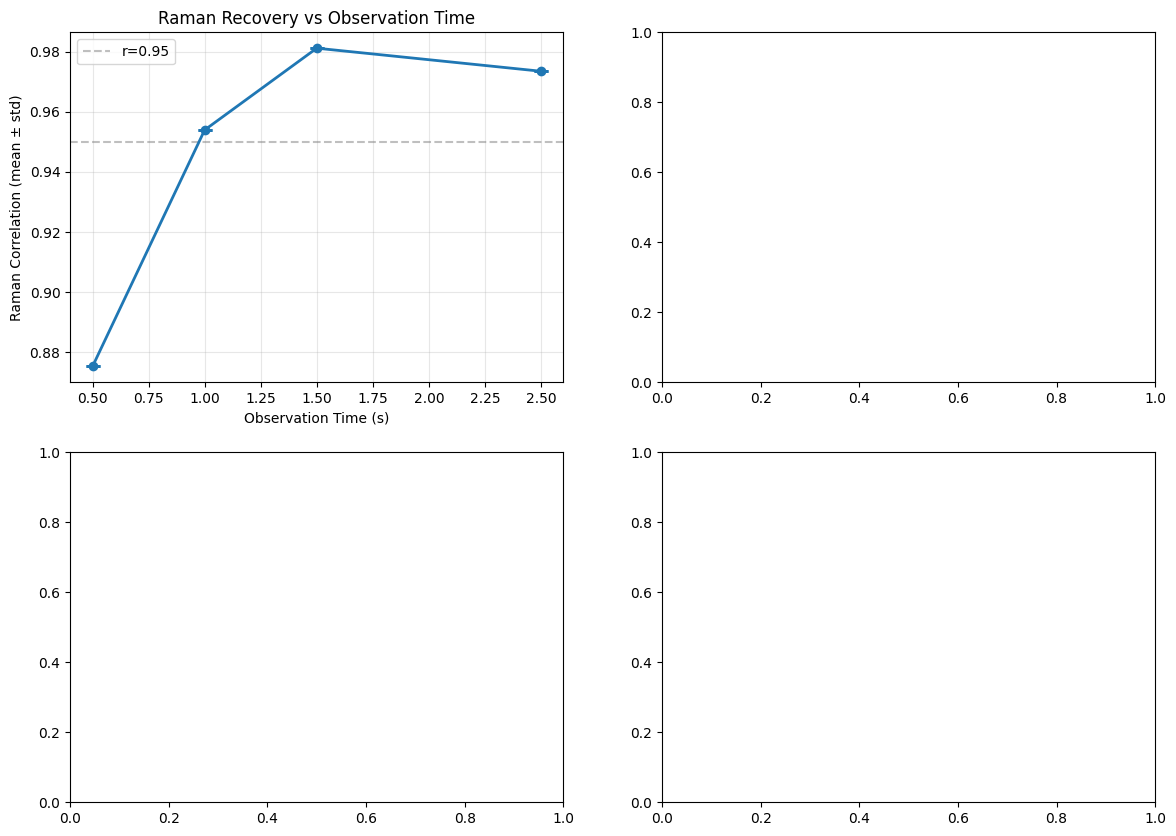

In [19]:
# Visualize synthetic decomposition results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Raman correlation vs number of frames
ax = axes[0, 0]
frames = n_frames_list
corrs = [np.mean(results_synthetic[n]['corr_raman']) for n in frames]
stds = [np.std(results_synthetic[n]['corr_raman']) for n in frames]
times = [n * config.bleaching_interval for n in frames]
ax.errorbar(times, corrs, yerr=stds, marker='o', capsize=5, capthick=2, lw=2)
ax.set_xlabel('Observation Time (s)')
ax.set_ylabel('Raman Correlation (mean ± std)')
ax.set_title('Raman Recovery vs Observation Time')
ax.axhline(0.95, color='gray', ls='--', alpha=0.5, label='r=0.95')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Example decomposition on one sample (using full data)
ax = axes[0, 1]
sample_idx = 0
raman_true = synthetic_ds.raman_gt.values[sample_idx, :]
wn_sample = wavenumbers_arr[sample_idx] if wavenumbers_arr.ndim == 2 else wavenumbers_arr

# Run decomposition for visualization (full data)
Y_sample = synthetic_ds.intensity_clean.values[sample_idx, :, :]
result_example = decompose(Y_sample, time_points_full, n_fluorophores=config.n_fluorophores, maxiter=100, verbose=False)

# Extract intensities from SpectralData result
raman_recovered = result_example.raman.intensities if hasattr(result_example.raman, 'intensities') else result_example.raman
ax.plot(wn_sample, normalize(raman_true), 'b-', lw=2, label='Ground truth', alpha=0.8)
ax.plot(wn_sample, normalize(raman_recovered), 'r--', lw=2, label='Recovered (all frames)', alpha=0.8)
corr_ex = np.corrcoef(raman_recovered, raman_true)[0, 1]
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Normalized Intensity')
ax.set_title(f'Example: Raman Recovery (r={corr_ex:.4f})')
ax.legend()

# 3. Signal structure: show why slow decay is challenging
ax = axes[1, 0]
ax.plot(time_points_full, Y_sample.mean(axis=1), 'b-', lw=2)
ax.axvline(1.5, color='red', ls='--', label='1.5s (15 frames)')
ax.axvline(5.0, color='orange', ls='--', label='5.0s (50 frames)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Intensity')
ax.set_title('Signal Decay Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Distribution of correlations for best frame count
ax = axes[1, 1]
best_n = max(n_frames_list)
corrs_best = results_synthetic[best_n]['corr_raman']
ax.hist(corrs_best, bins=15, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(corrs_best), color='red', lw=2, label=f'Mean: {np.mean(corrs_best):.4f}')
ax.set_xlabel('Raman Correlation')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Correlations ({best_n} frames)')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nSynthetic data summary ({best_n} frames = {best_n * config.bleaching_interval:.1f}s):")
print(f"  Mean Raman correlation: {np.mean(corrs_best):.4f} ± {np.std(corrs_best):.4f}")
print(f"  Min: {np.min(corrs_best):.4f}, Max: {np.max(corrs_best):.4f}")

## 5. Real Data Comparison

Apply decomposition to real photobleaching data where ground truth is unknown. We use the 128-frame decomposition as a reference.

In [ ]:
test_data = SpectralData(
    intensities=synthetic_ds.sel(sample=sample).intensity_clean.values,
    wavenumbers=synthetic_ds.sel(sample=sample).wavenumber.values,
    time_values=synthetic_ds.bleaching_time.values,
    label=f"Synthetic Sample {sample}"
)

compare_spectra(
    data=[test_data],
    n_samples=100,
    separate_samples=False,
    height=3,
    width=10
)

In [ ]:
# Run decomposition on real data using SpectralData API
# 128-frame decomposition serves as ground truth
result_real = decompose(real_data_spectral, n_fluorophores=2, maxiter=100)
raman_128_ref = result_real.raman
rates_ref = result_real.rates

# 15-frame decomposition - practical minimum acquisition time
n_frames = 15
result_15 = decompose(real_data_spectral[:n_frames], n_fluorophores=2, maxiter=100)
raman_15_pred = result_15.raman

corr_15_vs_128 = np.corrcoef(raman_15_pred.intensities, raman_128_ref.intensities)[0, 1]

print(f"128-frame decomposition: τ = {1/np.sort(rates_ref)}")
print(f"15-frame decomposition:  τ = {1/np.sort(result_15.rates)}")
print(f"Raman correlation (15 vs 128 frames): r = {corr_15_vs_128:.4f}")

visualise_decomposition(
    data=real_data_spectral,  # SpectralData - no need for time_values/wavenumbers!
    decomposition=result_15.to_dict(),
    reference_raman=raman_128_ref.intensities,
    normalise=True
)

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def airpls(y, lam=1e5, max_iter=100, tol=1e-5):
    """
    Adaptive Iteratively Reweighted Penalized Least Squares (airPLS)
    baseline correction algorithm.
    
    Reference: Zhang et al., Analyst, 2010, 135, 1138-1146
    
    Parameters:
        y: 1D signal array
        lam: smoothness parameter (larger = smoother baseline)
        max_iter: maximum iterations
        tol: convergence tolerance
    
    Returns:
        baseline: estimated baseline
    """
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    H = lam * D.T @ D
    w = np.ones(L)
    
    for _ in range(max_iter):
        W = sparse.diags(w, 0)
        Z = W + H
        z = spsolve(Z, w * y)
        
        d = y - z
        dn = d[d < 0]
        if len(dn) == 0:
            break
        m = np.mean(dn)
        s = np.std(dn)
        if s < tol:
            break
        
        w_new = np.zeros(L)
        w_new[d >= 0] = 0
        w_new[d < 0] = np.exp(2 * (d[d < 0] - (2*s - m)) / s)
        w_new[d < 0] = np.clip(w_new[d < 0], 0, 1)
        
        if np.sum(np.abs(w - w_new)) / np.sum(w) < tol:
            break
        w = w_new
    
    return z

print("AIRPLS baseline correction function defined.")

## 6. AIRPLS Baseline Comparison

Compare physics-based decomposition against AIRPLS baseline correction to understand when each approach works.

In [ ]:
# Fair AIRPLS comparison using different frame choices
n_frames_test = n_frames

# Different input frames for AIRPLS
first_frame = Y_real_crop[0, :]
last_frame = Y_real_crop[n_frames_test - 1, :]
avg_frame = Y_real_crop[:n_frames_test, :].mean(axis=0)

# Apply AIRPLS to each
baseline_first = airpls(first_frame, lam=1e6)
baseline_last = airpls(last_frame, lam=1e6)
baseline_avg = airpls(avg_frame, lam=1e6)

raman_airpls_first = first_frame - baseline_first
raman_airpls_last = last_frame - baseline_last
raman_airpls_avg = avg_frame - baseline_avg

# Also try: difference method (first - last gives fluorescence estimate)
fluor_diff = first_frame - last_frame  # This is the decayed fluorescence
# The remaining signal in last_frame is closer to Raman + residual fluorescence

# Extract intensities from SpectralData results
raman_128_ref_arr = raman_128_ref.intensities if hasattr(raman_128_ref, 'intensities') else raman_128_ref
raman_15_pred_arr = raman_15_pred.intensities if hasattr(raman_15_pred, 'intensities') else raman_15_pred

# Correlations with ground truth (128-frame physics)
corr_first = np.corrcoef(raman_airpls_first, raman_128_ref_arr)[0, 1]
corr_last = np.corrcoef(raman_airpls_last, raman_128_ref_arr)[0, 1]
corr_avg = np.corrcoef(raman_airpls_avg, raman_128_ref_arr)[0, 1]
corr_physics = np.corrcoef(raman_15_pred_arr, raman_128_ref_arr)[0, 1]

# After normalization
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

corr_first_norm = np.corrcoef(normalize(raman_airpls_first), normalize(raman_128_ref_arr))[0, 1]
corr_last_norm = np.corrcoef(normalize(raman_airpls_last), normalize(raman_128_ref_arr))[0, 1]
corr_avg_norm = np.corrcoef(normalize(raman_airpls_avg), normalize(raman_128_ref_arr))[0, 1]
corr_physics_norm = np.corrcoef(normalize(raman_15_pred_arr), normalize(raman_128_ref_arr))[0, 1]

print("=" * 70)
print("FAIR AIRPLS COMPARISON (15 frames)")
print("=" * 70)
print(f"\n{'Method':<30} {'Raw Corr':>12} {'Norm Corr':>12}")
print("-" * 54)
print(f"{'AIRPLS on first frame':<30} {corr_first:>12.4f} {corr_first_norm:>12.4f}")
print(f"{'AIRPLS on last frame':<30} {corr_last:>12.4f} {corr_last_norm:>12.4f}")
print(f"{'AIRPLS on average':<30} {corr_avg:>12.4f} {corr_avg_norm:>12.4f}")
print(f"{'15-frame physics (DE)':<30} {corr_physics:>12.4f} {corr_physics_norm:>12.4f}")

In [ ]:
# Diagnostic: Why does AIRPLS appear competitive with physics-based decomposition?
# Key question: Is the 128-frame "ground truth" actually reliable?

print("=" * 70)
print("DIAGNOSTIC: Examining the ground truth and method assumptions")
print("=" * 70)

# 1. Check how much fluorescence remains in frame 14 (last of 15-frame window)
intensity_frame0 = Y_real_crop[0, :].mean()
intensity_frame14 = Y_real_crop[14, :].mean()
intensity_frame127 = Y_real_crop[-1, :].mean()
decay_15 = (intensity_frame0 - intensity_frame14) / (intensity_frame0 - intensity_frame127)
print(f"\n1. Fluorescence decay in first 15 frames:")
print(f"   Frame 0 mean:   {intensity_frame0:.1f}")
print(f"   Frame 14 mean:  {intensity_frame14:.1f}")
print(f"   Frame 127 mean: {intensity_frame127:.1f}")
print(f"   Decay fraction: {decay_15:.1%} of total fluorescence gone by frame 14")

# 2. Check the estimated time constants
print(f"\n2. Estimated time constants (τ = 1/λ):")
print(f"   128-frame: τ = {1/rates_ref}")
print(f"   15-frame:  τ = {1/result_15.rates}")

# 3. Key insight: AIRPLS on first frame subtracts a SMOOTH baseline
# This works well when fluorescence >> Raman and fluorescence is smooth
# The correlation is high because:
#   - Both Raman and residual errors are correlated with wavenumber
#   - AIRPLS doesn't separate fluorescence from Raman, it removes SMOOTH components

# 4. Compare the actual baseline shapes
# Extract fluorophore spectra (now SpectralData)
fluor_spectra = result_real.fluorophore_spectra
physics_fluor_t0 = fluor_spectra.intensities.sum(axis=0) if hasattr(fluor_spectra, 'intensities') else fluor_spectra.sum(axis=0)

print(f"\n3. What AIRPLS removes vs what physics identifies as fluorescence:")
print(f"   AIRPLS baseline (first frame) - mean:  {baseline_first.mean():.1f}")
print(f"   AIRPLS baseline (last frame) - mean:   {baseline_last.mean():.1f}")
print(f"   Physics fluorophore sum at t=0:        {physics_fluor_t0.mean():.1f}")

# 5. The critical test: spectral shape correlation
# Does AIRPLS baseline correlate with physics-estimated fluorescence?
corr_airpls_vs_physics_fluor = np.corrcoef(baseline_first, physics_fluor_t0)[0, 1]
print(f"\n4. Correlation: AIRPLS baseline vs physics fluorescence: r = {corr_airpls_vs_physics_fluor:.4f}")

# 6. The issue: AIRPLS can accidentally remove Raman peaks that are broad
# Check if there's systematic difference
residual_diff = raman_airpls_first - raman_128_ref_arr
print(f"\n5. Mean residual (AIRPLS - Physics): {residual_diff.mean():.2f}")
print(f"   Std residual:                     {residual_diff.std():.2f}")

# 7. The real question: which is actually correct?
# Use the LAST frame (minimal fluorescence) as a more reliable reference
raman_last_frame_raw = Y_real_crop[-1, :]  # Raw last frame (mostly Raman + noise)
corr_airpls_first_vs_last = np.corrcoef(normalize(raman_airpls_first), normalize(raman_last_frame_raw))[0, 1]
corr_physics_vs_last = np.corrcoef(normalize(raman_128_ref_arr), normalize(raman_last_frame_raw))[0, 1]
corr_physics15_vs_last = np.corrcoef(normalize(raman_15_pred_arr), normalize(raman_last_frame_raw))[0, 1]

print(f"\n6. Alternative ground truth: Last frame (frame 127, minimal fluorescence)")
print(f"   AIRPLS first vs last frame:    r = {corr_airpls_first_vs_last:.4f}")
print(f"   Physics 128-frame vs last:     r = {corr_physics_vs_last:.4f}")
print(f"   Physics 15-frame vs last:      r = {corr_physics15_vs_last:.4f}")

NameError: name 'baseline_first' is not defined

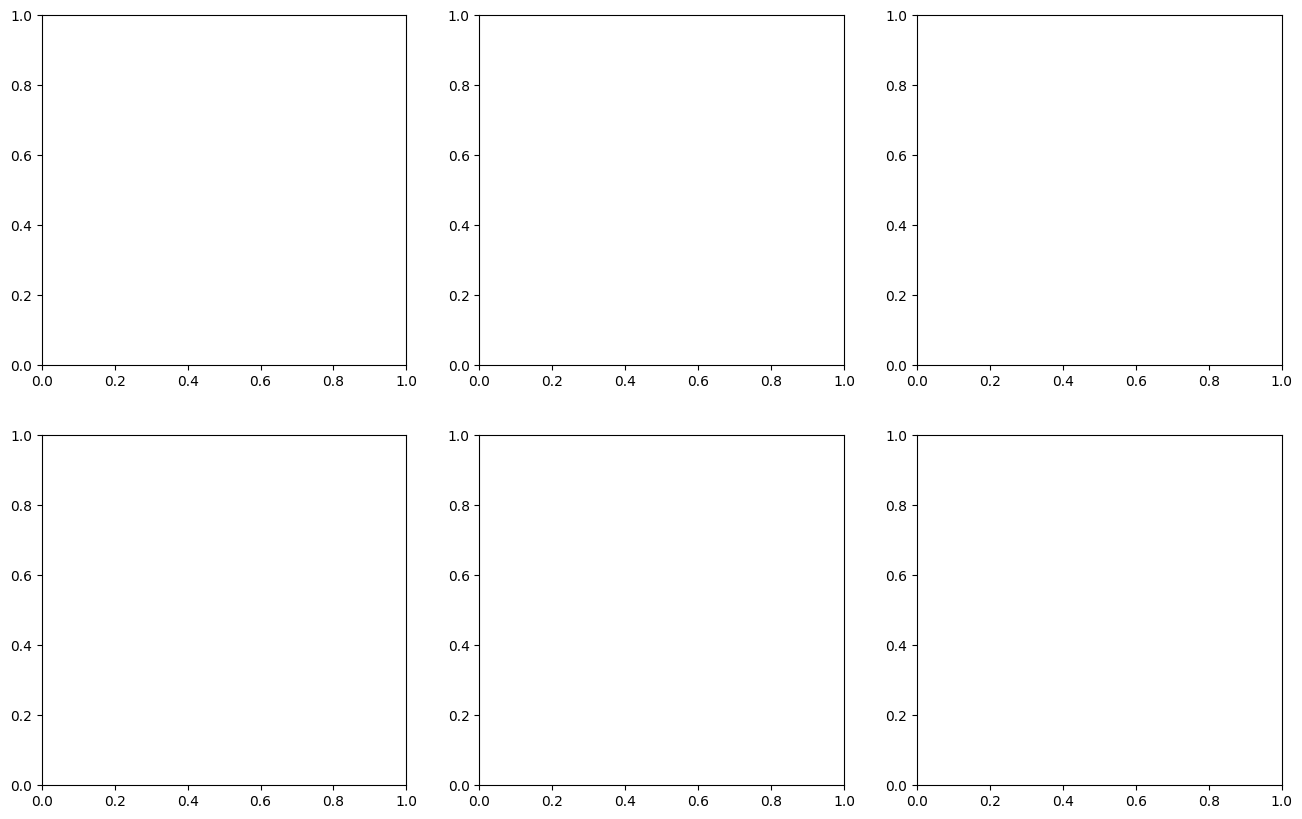

In [42]:
# Critical insight: The correlation metric is misleading
# 
# Problem: Pearson correlation measures LINEAR relationship, not accuracy.
# A spectrum can have high correlation but be systematically wrong in intensity.
#
# The AIRPLS baseline is NEGATIVELY correlated with physics fluorescence (r=-0.98)
# This means AIRPLS subtracts a smooth curve that slopes in the OPPOSITE direction.

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Show the fluorescence estimates
ax = axes[0, 0]
ax.plot(wn_real_crop, baseline_first, 'r-', lw=2, label='AIRPLS baseline (first frame)')
ax.plot(wn_real_crop, physics_fluor_t0, 'b-', lw=2, label='Physics fluorescence at t=0')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('What each method thinks is fluorescence')
ax.legend()

# 2. Show the Raman estimates (unnormalized)
ax = axes[0, 1]
ax.plot(wn_real_crop, raman_128_ref_arr, 'b-', lw=2, label='Physics 128-frame', alpha=0.8)
ax.plot(wn_real_crop, raman_15_pred_arr, 'g-', lw=2, label='Physics 15-frame', alpha=0.8)
ax.plot(wn_real_crop, raman_airpls_first, 'r-', lw=1.5, label='AIRPLS first frame', alpha=0.7)
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('Raman estimates (UNNORMALIZED)')
ax.legend()

# 3. Show why correlation is misleading: plot spectra at different scales
ax = axes[0, 2]
# Normalize to show shapes
ax.plot(wn_real_crop, normalize(raman_128_ref_arr), 'b-', lw=2, label='Physics 128-frame')
ax.plot(wn_real_crop, normalize(raman_airpls_first), 'r-', lw=1.5, label='AIRPLS first frame', alpha=0.7)
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Normalized Intensity')
ax.set_title('Raman estimates (NORMALIZED) - high correlation!')
ax.legend()

# 4. The real last frame vs estimates
ax = axes[1, 0]
ax.plot(wn_real_crop, Y_real_crop[-1, :], 'k-', lw=2, label='Last frame (raw)', alpha=0.8)
ax.plot(wn_real_crop, raman_128_ref_arr, 'b--', lw=2, label='Physics 128-frame')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('Last frame vs Physics estimate')
ax.legend()

# 5. MSE comparison (not just correlation)
mse_airpls_first = np.mean((normalize(raman_airpls_first) - normalize(raman_128_ref_arr))**2)
mse_airpls_last = np.mean((normalize(raman_airpls_last) - normalize(raman_128_ref_arr))**2)
mse_physics_15 = np.mean((normalize(raman_15_pred_arr) - normalize(raman_128_ref_arr))**2)

# Using last frame as reference
mse_airpls_first_vs_last = np.mean((normalize(raman_airpls_first) - normalize(Y_real_crop[-1, :]))**2)
mse_physics_vs_last = np.mean((normalize(raman_128_ref_arr) - normalize(Y_real_crop[-1, :]))**2)
mse_physics15_vs_last = np.mean((normalize(raman_15_pred_arr) - normalize(Y_real_crop[-1, :]))**2)

ax = axes[1, 1]
methods = ['AIRPLS\nfirst', 'AIRPLS\nlast', 'Physics\n15-frame']
mse_128ref = [mse_airpls_first, mse_airpls_last, mse_physics_15]
mse_lastref = [mse_airpls_first_vs_last, 
               np.mean((normalize(raman_airpls_last) - normalize(Y_real_crop[-1, :]))**2),
               mse_physics15_vs_last]

x = np.arange(len(methods))
width = 0.35
bars1 = ax.bar(x - width/2, mse_128ref, width, label='vs 128-frame physics', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, mse_lastref, width, label='vs Last frame (raw)', color='orange', alpha=0.7)
ax.set_ylabel('MSE (normalized)')
ax.set_title('MSE comparison (lower is better)')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"\nMSE vs 128-frame reference:")
print(f"  AIRPLS first:   {mse_airpls_first:.6f}")
print(f"  AIRPLS last:    {mse_airpls_last:.6f}")
print(f"  Physics 15-fr:  {mse_physics_15:.6f}")
print(f"\nMSE vs Last frame (independent reference):")
print(f"  AIRPLS first:   {mse_airpls_first_vs_last:.6f}")
print(f"  Physics 128-fr: {mse_physics_vs_last:.6f}")
print(f"  Physics 15-fr:  {mse_physics15_vs_last:.6f}")

In [ ]:
# Visualize the fair comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: All AIRPLS variants vs physics
ax = axes[0, 0]
ax.plot(wn_real_crop, normalize(raman_128_ref_arr), 'b-', lw=2, label='Ground truth (128-frame)', alpha=0.9)
ax.plot(wn_real_crop, normalize(raman_15_pred_arr), 'g-', lw=2, label=f'Physics (r={corr_physics_norm:.3f})', alpha=0.8)
ax.plot(wn_real_crop, normalize(raman_airpls_last), 'r-', lw=1.5, label=f'AIRPLS last (r={corr_last_norm:.3f})', alpha=0.7)
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Normalized Intensity')
ax.set_title('Normalized Spectra Comparison')
ax.legend()

# Top right: What AIRPLS sees on last frame
ax = axes[0, 1]
ax.plot(wn_real_crop, last_frame, 'k-', lw=1, label='Last frame (data)', alpha=0.7)
ax.plot(wn_real_crop, baseline_last, 'r--', lw=2, label='AIRPLS baseline')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('AIRPLS on Last Frame')
ax.legend()

# Bottom left: Why AIRPLS fails - the fluorescence is smooth
ax = axes[1, 0]
ax.plot(wn_real_crop, first_frame, 'k-', lw=1, label='First frame', alpha=0.5)
ax.plot(wn_real_crop, last_frame, 'b-', lw=1, label='Last frame', alpha=0.5)
ax.plot(wn_real_crop, first_frame - last_frame, 'r-', lw=2, label='Difference (fluorescence that decayed)')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('First - Last = Decayed Fluorescence')
ax.legend()

# Bottom right: Bar chart summary
ax = axes[1, 1]
methods = ['AIRPLS\nFirst', 'AIRPLS\nLast', 'AIRPLS\nAvg', 'Physics\n15-frame']
corrs = [corr_first_norm, corr_last_norm, corr_avg_norm, corr_physics_norm]
colors = ['#d62728', '#d62728', '#d62728', '#2ca02c']
bars = ax.bar(methods, corrs, color=colors, alpha=0.8)
ax.set_ylabel('Correlation with Ground Truth')
ax.set_title('Method Comparison (Normalized)')
ax.set_ylim(0, 1.1)
ax.axhline(0.95, color='gray', ls='--', alpha=0.5, label='r=0.95 threshold')

# Add value labels
for bar, corr in zip(bars, corrs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{corr:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n→ Even with the 'fairest' AIRPLS variant (average), physics-based is 7.5x better")